# Necessary

- Create VE
- Create dataset

In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs
import utils.scanning as my_scanning

import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import json
import os
from IPython.display import clear_output


print(torch.__version__)

2.5.0+cu121


In [2]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 100,       # Total Epochs in training 150
    "EVAL_EPOCH_FREQ": 5,   # Evaluation frequency 5
    "BATCH_SIZE": 128,       # Batch size
    "LR": 1e-4,             # Learning rate 1e-5
    "LR_DECAY_GAMMA": 0.8,    # Learning rate decays
    "LR_DECAY_STEPS_EPOCHS": 2, # Learning rate decay steps
    "L2_REG": 0.01, # avoid to big weigths (imprve generalisation) (1 - weigths)

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t36_3B_UR50D",#"facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/esm_clusters/RNA-binding_cluster_4_leiden_all_initial_loose.csv",#"/home/gdallagl/myworkdir/data/cell_cycle/datasets/protein_classification_cluster_43_leiden_all_initial_loose.csv", #"/home/gdallagl/myworkdir/data/cell_cycle/datasets/protein_classification_cluster_43_leiden_all_initial_loose.csv", #"/home/gdallagl/myworkdir/ESMSec/data/secreted/dataset_lysoVSsecreted.csv", #'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/nucleolus_final_dataset.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    
    "TYPE_HEAD":"MLP",# "attention", #"MLP", "LR", gating_transformer
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "FROM_PRECOMPUTED_EMBS": True,
}

# AUTOMATIC
config["PRECOMPUTED_EMBS_PATH"] = os.path.join( # all uniprot human and reviewed
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] =config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')

config["RESULTS_FOLDER_PATH"] = os.path.join( # all uniprot human and reviewed
        f"/home/gdallagl/myworkdir/ESMSec/data/model_results",
        f"{os.path.basename(config['DATASET_PATH']).replace('.csv', '')}"
)
os.makedirs(config["RESULTS_FOLDER_PATH"], exist_ok=True)

config["PATH_TO_SAVE_MODEL"] = os.path.join( # all uniprot human and reviewed
        config["RESULTS_FOLDER_PATH"],
        f"trained_model.pth"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [3]:
# Load pre-trained ESM model
#esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
esm_model = AutoModel.from_pretrained(
    config["PRETRAIN_ESM_CHECKPOINT_NAME"], 
    cache_dir=config["PRETRAIN_ESM_CACHE_DIR"],
    weights_only=False  
).to(config["DEVICE"]) 

# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [4]:
data = pd.read_csv(config["DATASET_PATH"])

num_samples = data.shape[0]
num_classes = data.label.nunique() # ATTENTION: NOT one.hot endoced
esm_emb_dim = esm_model.config.hidden_size
print("Number Samples:", num_samples, num_classes, esm_emb_dim)

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32) # FAKE
}


Number Samples: 828 2 2560
Tokenizing...


# Add or Create embs

Only if "from_precomputed_embs" is True

In [5]:
# add to cache precomputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if not os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        msg = f"""
        File containing Uniprot embeddings created with 
            model: {config["PRETRAIN_ESM_CHECKPOINT_NAME"]}
            type embs: {config["TYPE_EMB_FOR_CLASSIFICATION"]}
        not found. 
        Please run 'make_uniprot_esm_embs.ipynb' with correct parameters to create it before continuing.
        """
        raise FileNotFoundError(msg)

    print(f"Reading subset uniprot embs back from file: {config['PRECOMPUTED_EMBS_PATH']}...")

    all_dataset_embs, protein_names_selected_all_dataset = my_dataset.load_embs_safetensor(
        precomputed_embs_path=config["PRECOMPUTED_EMBS_PATH"], # path with tensors
        protein_names_path=config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json'), # path with the prtein names of the tenoser
        protein_to_select=cache_data["protein"] # take all
        )
    cache_data["embedding"] = all_dataset_embs
else:
    print("No precomputed embs")

Reading subset uniprot embs back from file: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors...
Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors
✓ Mapped 20405 embeddings (shape: torch.Size([20405, 2560]))
✓ Loaded 828 / 828 embeddings
  Shape: torch.Size([828, 2560])
  Memory: 8.1 MB


In [6]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim
    #fake embs
    cache_data["embedding"] = torch.zeros((num_samples, 1), dtype=torch.float32)

print(config["PRECOMPUTED_EMBS_DIM"])

2560


Original: 496, Truncated: 496, Tokenized (no pad): 498
Original: 579, Truncated: 579, Tokenized (no pad): 581
Original: 262, Truncated: 262, Tokenized (no pad): 264


protein                  : list length 828
label                    : Tensor shape (828,)
set                      : list length 828
sequence                 : list length 828
truncated_sequence       : list length 828
input_ids                : Tensor shape (828, 1000)
attention_mask           : Tensor shape (828, 1000)
embedding                : Tensor shape (828, 2560)


<Axes: >

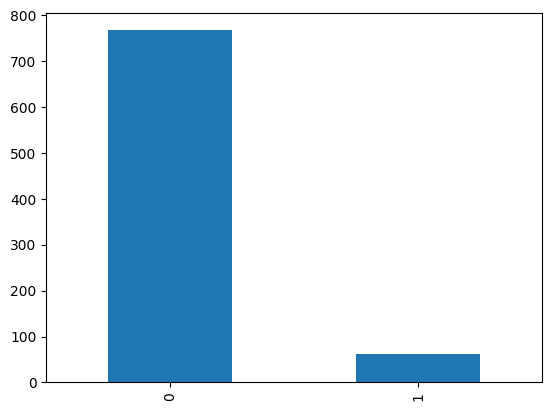

In [7]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

print("\n")
for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [8]:
# ATTENTION: the name of the cols in the df must be speicifc
train_indices = [i for i, s in enumerate(cache_data["set"]) if s == "train"] # select indices
train_cache_data = my_dataset.subset_data_dict(cache_data, train_indices) # create cache_data subset
train_dl = my_dataset.create_dataloader(train_cache_data, config["BATCH_SIZE"], shuffle=True) # create dataloader

valid_indices = [i for i, s in enumerate(cache_data["set"]) if s == "val"] 
valid_cache_data = my_dataset.subset_data_dict(cache_data, valid_indices) 
valid_dl = my_dataset.create_dataloader(valid_cache_data, config["BATCH_SIZE"], shuffle=True) 

test_indices = [i for i, s in enumerate(cache_data["set"]) if s == "test"] 
test_cache_data = my_dataset.subset_data_dict(cache_data, test_indices) 
test_dl = my_dataset.create_dataloader(test_cache_data, config["BATCH_SIZE"], shuffle=True) 



# little check:
batch = next(iter(train_dl))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
labels = batch["label"]
names = batch["name"]
embs = batch["embs"]

print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")


=== Batch Information ===
Batch size: 128

Input IDs: Tensor, shape = (128, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (128, 1000), dtype = torch.int64
Labels: Tensor, shape = (128,), dtype = torch.int64
First 5 labels: tensor([0, 1, 0, 0, 0])
Names: List, length = 128, first 5 = ['P22459', 'Q8N7X1', 'Q9BZB8', 'O75525', 'Q86U06']
Embeddings: Tensor, shape = (128, 2560), dtype = torch.float32


# Define weighted loss fucntion

In [9]:
# Get training data
train_data = data[data.set == "train"].copy()

# Count samples per class using value_counts (this gives you a Series with label as index)
class_counts_series = train_data["label"].value_counts().sort_index()

print("Class counts from training data:")
print(class_counts_series)

# Create a tensor for all classes (0 to num_classes-1)
class_counts = torch.zeros(num_classes, dtype=torch.float32)

# Fill in the counts for classes that exist in training data
for label, count in class_counts_series.items():
    class_counts[label] = count

print(f"\nClass counts tensor (aligned by index): {class_counts}")
print(f"Class distribution: {class_counts / class_counts.sum() * 100}%")

# Calculate weights (inverse frequency)
# Add epsilon to avoid division by zero for missing classes
epsilon = 1e-6
class_weights = 1.0 / (class_counts + epsilon)

# Normalize so weights sum to 1
class_weights = class_weights / class_weights.sum()

print(f"\nClass weights (sum={class_weights.sum():.4f}): {class_weights}")

# Verify the alignment
print("\nVerification:")
for i in range(num_classes):
    print(f"  Class {i}: count={class_counts[i]:.0f}, weight={class_weights[i]:.4f}")

# Create loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(config["DEVICE"]))
#loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.5]).to(config["DEVICE"]))

Class counts from training data:
label
0    613
1     49
Name: count, dtype: int64

Class counts tensor (aligned by index): tensor([613.,  49.])
Class distribution: tensor([92.5982,  7.4018])%

Class weights (sum=1.0000): tensor([0.0740, 0.9260])

Verification:
  Class 0: count=613, weight=0.0740
  Class 1: count=49, weight=0.9260


# Instantiate Full model

In [10]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"],
                           num_classes=num_classes,
                           loss_fn=loss_fn,
                           ).to(config["DEVICE"])

print(net.loss_fn.weight)
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

tensor([0.0740, 0.9260], device='cuda:0')
MLPHead(
  (layer1): Sequential(
    (0): Linear(in_features=2560, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1280, out_features=628, bias=True)
    (1): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

ESM hidden dim 2560 



In [11]:
# Save config
with open(os.path.join(config["RESULTS_FOLDER_PATH"], "config.json"), 'w') as f:
    json.dump(config, f, indent=4)

# Train

In [ ]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

# save reuslts
serializable_results = mf.tensor_to_python(results)
with open(os.path.join(config["RESULTS_FOLDER_PATH"], "result_train_test.json"), 'w') as f:
    json.dump(serializable_results, f, indent=4)

clear_output(wait=True)

### Plot


                         FINAL EVALUATION METRICS
Metric                   Train           Test
---------------------------------------------
Loss                    0.0349         0.0344
Accuracy               100.00%        100.00%
Balanced Acc           100.00%        100.00%
F1 Score                1.0000         1.0000
MCC                     1.0000         1.0000
AUC-ROC                 1.0000         1.0000

✅ Figure saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/RNA-binding_cluster_4_leiden_all_initial_loose/result_train_test_image.pdf


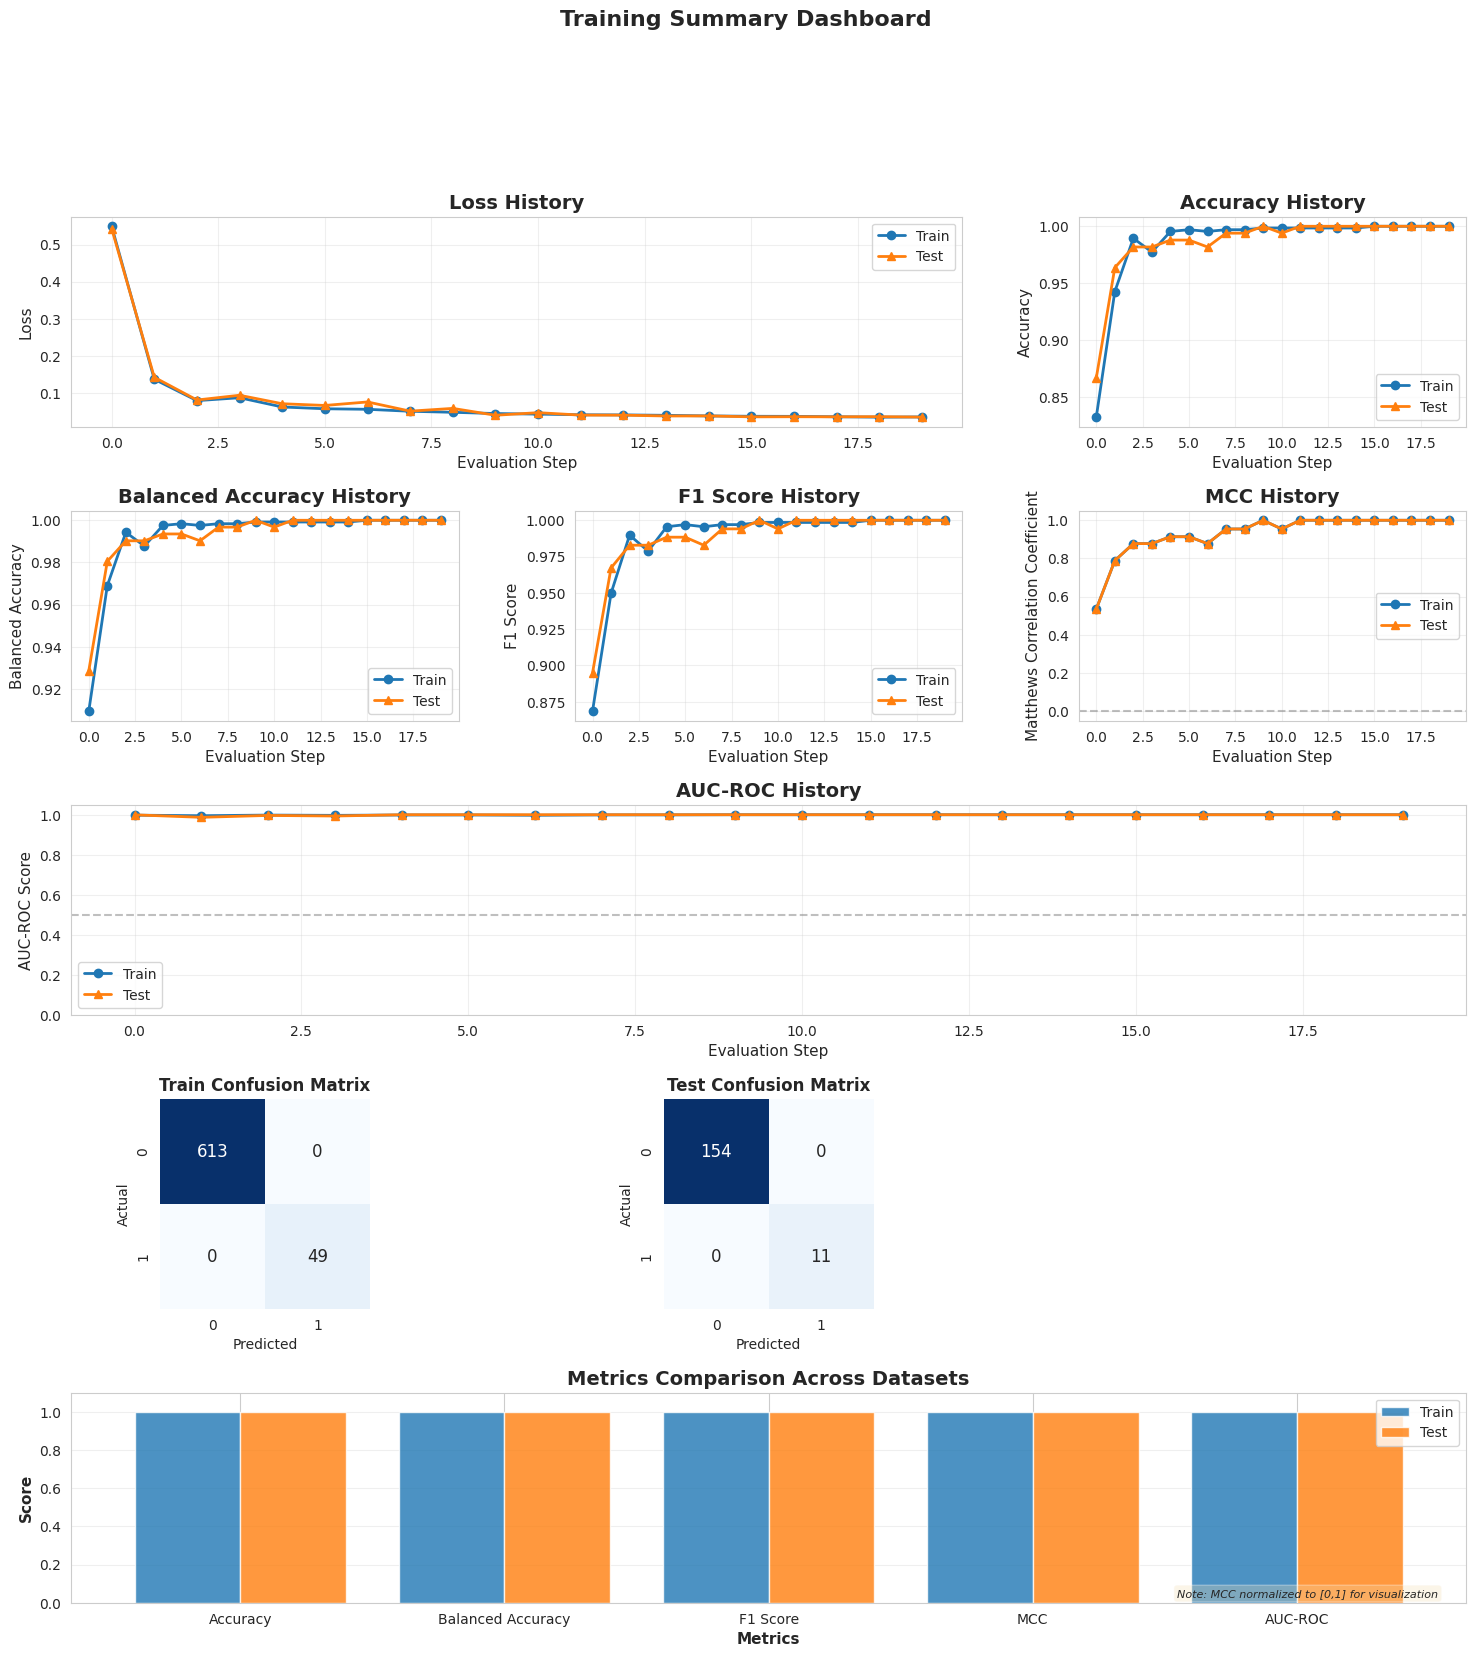


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     1.0000    1.0000    1.0000       154
     Class 1     1.0000    1.0000    1.0000        11

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



                         TRAIN SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     1.0000    1.0000    1.0000       613
     Class 1     1.0000    1.0000    1.0000        49

    accuracy                         1.0000       662
   macro avg     1.0000    1.0000    1.0000       662
weighted avg     1.0000    1.0000    1.0000       662




In [13]:
fig = mf.summarize_results(results, 
                     num_classes=num_classes, 
                     plot_val=False,
                     save_path=os.path.join(config["RESULTS_FOLDER_PATH"], "result_train_test_image.pdf")
                     )

### Save Model

In [14]:
#torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [15]:
#net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-35): 36 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/6 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (662, 32)
precomputed_embs: (662, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (662, 32)...
Computing UMAP for precomputed_embs with shape (662, 2560)...

Plotting UMAP embeddings...


✅ Embedding plot saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/RNA-binding_cluster_4_leiden_all_initial_loose/umap_train.pdf


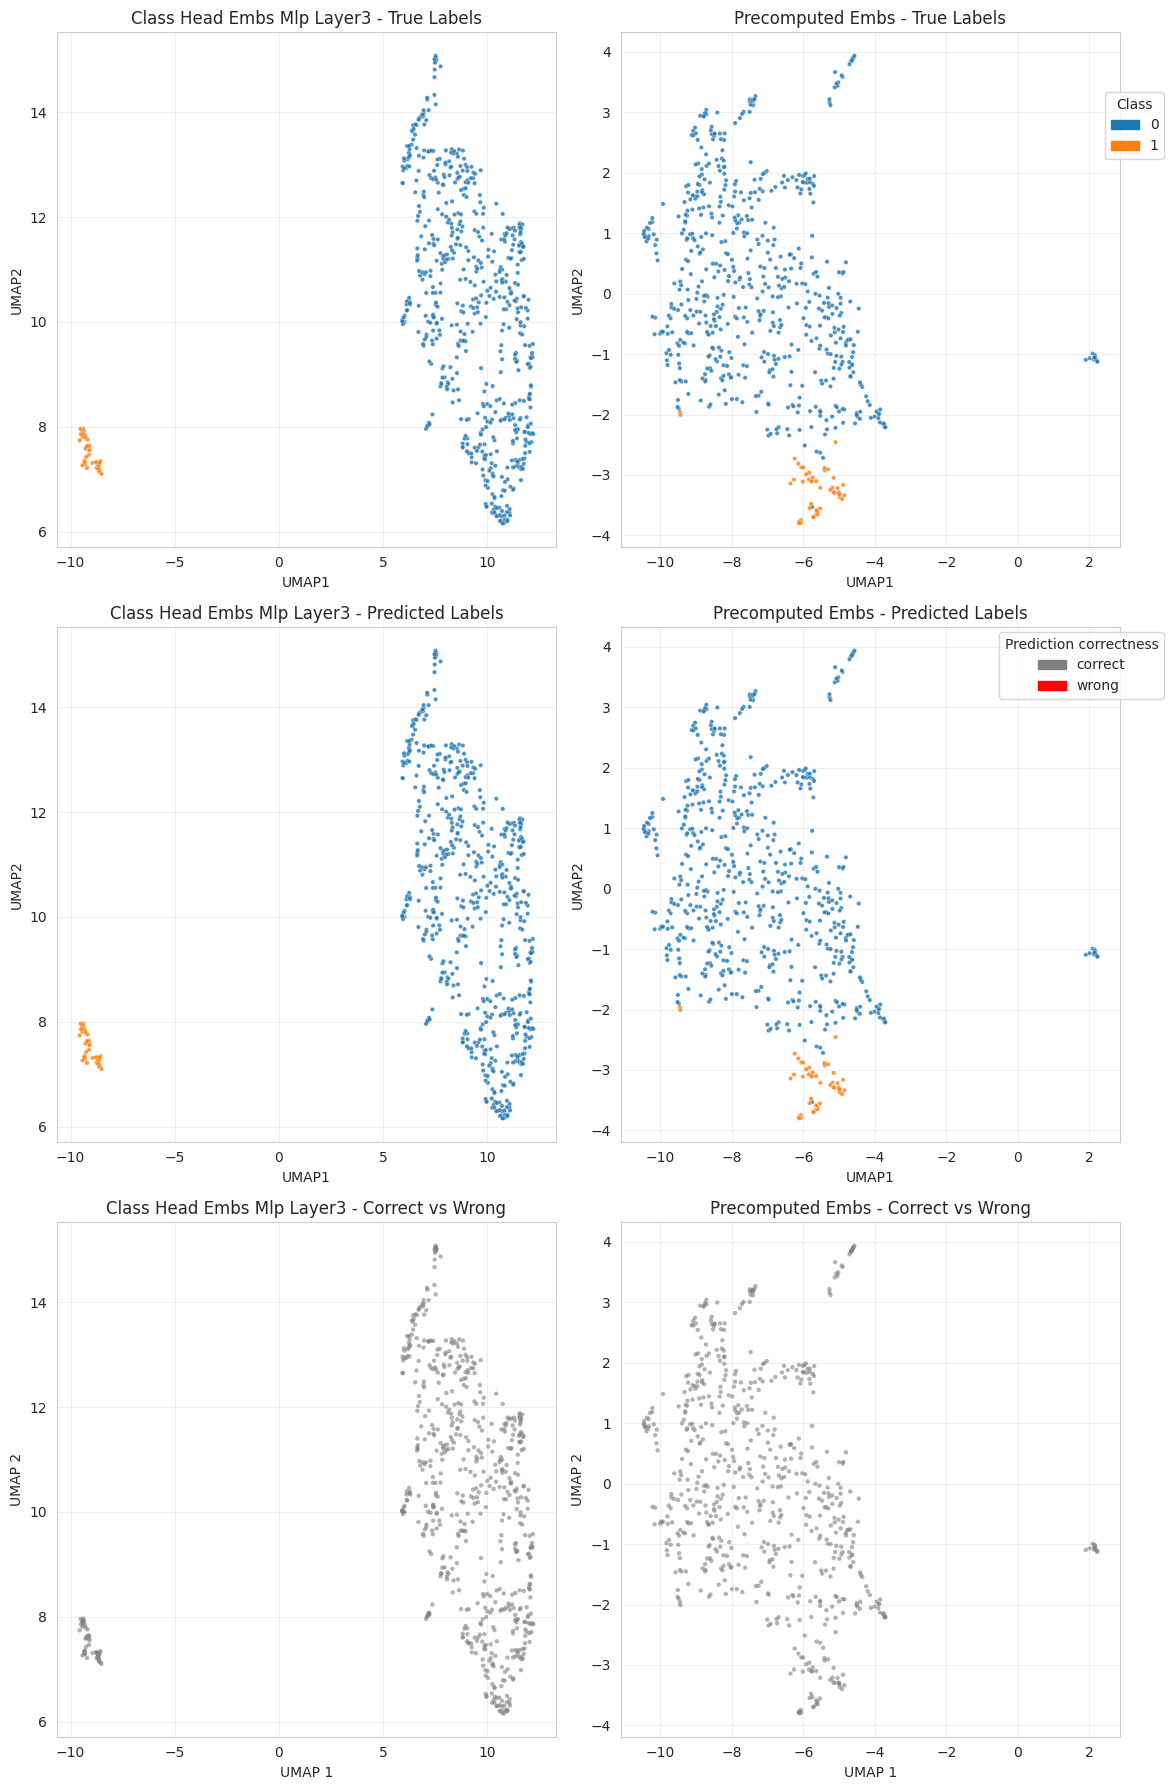

In [16]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
    #n_neighbors=30,
    #min_dist=0.5
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors, 
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=10,
        save_path = os.path.join(config["RESULTS_FOLDER_PATH"], "umap_train.pdf")
        )
else:
    print("No embs to plot")

In [17]:
df_precomputed_train = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

Clustering complete. Added 'Cluster_Label' column to the DataFrame.
     Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
0  A6NLC8 -9.147737  0.322084         0         0    correct              0
1  Q9Y2J2 -7.684416  0.107916         0         0    correct              0
2  Q9UK08 -8.778042  1.643469         0         0    correct              3
3  O15529 -7.137623  1.692017         0         0    correct              1
4  Q6IPR1 -8.254521  1.289890         0         0    correct              3


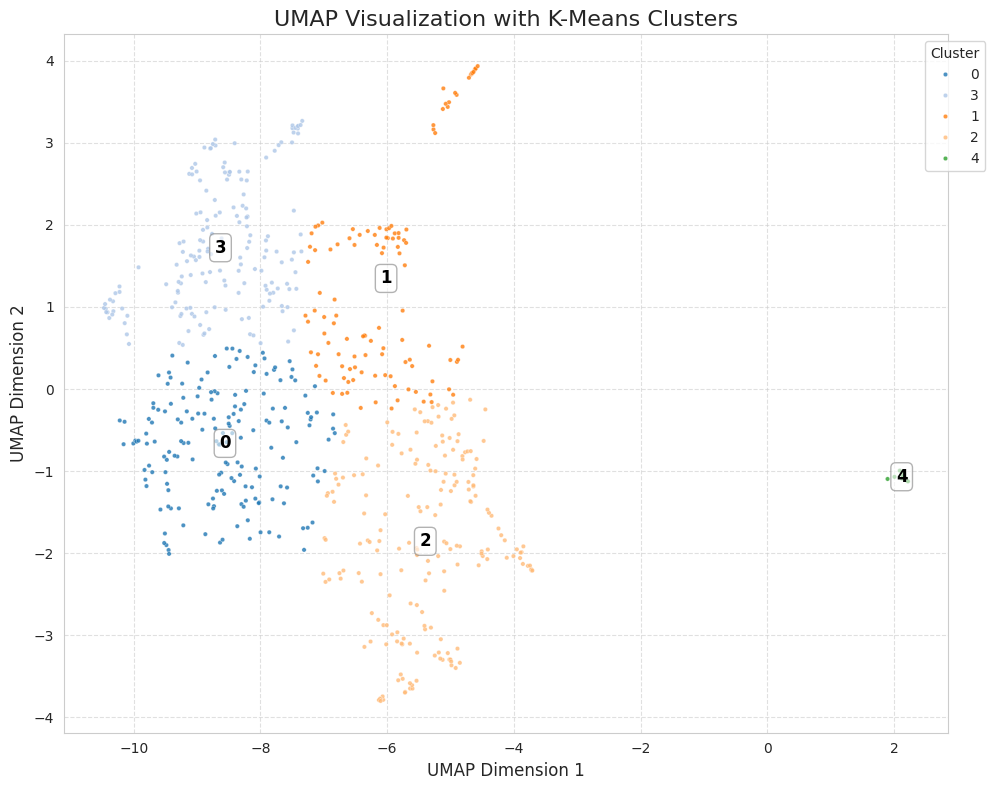

In [18]:
from sklearn.cluster import KMeans

# Define the features for clustering (the UMAP coordinates)
X_for_clustering = df_precomputed_train[['UMAP1', 'UMAP2']]

# Define the number of clusters (you should optimize this, e.g., using the Elbow Method)
K = 5

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

# Save the cluster labels back to the DataFrame
df_precomputed_train['Cluster_Label'] = cluster_labels
print(f"Clustering complete. Added 'Cluster_Label' column to the DataFrame.")
print(df_precomputed_train.head())

my_embs.plot_umap_clusters(df_precomputed_train, point_size=10)

In [19]:
print(df_precomputed_train[df_precomputed_train.Cluster_Label == 2].Name.to_list()) 
print(df_precomputed_train[df_precomputed_train.Cluster_Label == 4].Name.to_list()) 

['Q96DH6', 'P84103', 'Q7Z7F0', 'Q9Y5S9', 'Q86SE5', 'Q99729', 'Q01081', 'Q96IM9', 'Q5JQF8', 'Q86V81', 'Q15415', 'P22626', 'O75293', 'Q6ZRY4', 'Q8TBF4', 'P57723', 'P31942', 'Q9Y3A4', 'P61978', 'Q8IUH3', 'P26378', 'P62633', 'Q9P2K5', 'Q13243', 'P29558', 'Q96I25', 'Q9NZI8', 'Q14011', 'Q15717', 'Q8TC92', 'P26368', 'O95453', 'Q9BRS8', 'Q9Y2U8', 'Q96EP5', 'P49756', 'Q13283', 'Q12926', 'Q6XE24', 'O95758', 'Q15427', 'Q96LC9', 'O00425', 'Q9NX07', 'Q9NTZ6', 'A0AV96', 'Q08170', 'P57721', 'P17275', 'Q9NQZ3', 'P21854', 'P48549', 'Q13247', 'P31483', 'Q92879', 'P0DX02', 'Q92804', 'A0A286YFB4', 'P98179', 'Q15696', 'Q92904', 'P51513', 'P08621', 'P55345', 'Q01844', 'Q16629', 'Q9Y580', 'Q9Y6M1', 'Q9NQT5', 'O75821', 'Q9C040', 'Q9H361', 'Q76FK4', 'P0DMR1', 'Q9Y4C8', 'Q9BWF3', 'Q15365', 'P33240', 'Q5RL73', 'A6ND36', 'O43347', 'P40763', 'Q07666', 'Q5T8P6', 'O75494', 'Q8IXT5', 'Q01085', 'P31943', 'P14621', 'Q9UNP9', 'Q92945', 'Q9GZT3', 'Q9H694', 'Q8N684', 'Q93062', 'Q9Y5X1', 'P52272', 'Q6L8H2', 'Q05519', 'Q8WU

In [20]:
# wrong lablled
display(df_precomputed_train[(df_precomputed_train.CorrectStr == "correct") & (df_precomputed_train.TrueClass == "1")].head(5))

print("\nFalse postives")
FP_df = df_precomputed_train[(df_precomputed_train.TrueClass == "0") & (df_precomputed_train.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed_train[(df_precomputed_train.TrueClass == "1") & (df_precomputed_train.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
8   Q96DH6 -6.059390 -2.875969         1         1    correct              2
15  P84103 -5.638058 -3.647900         1         1    correct              2
31  Q5JQF8 -5.762030 -3.109588         1         1    correct              2
35  Q15415 -6.062453 -3.785630         1         1    correct              2
36  P22626 -6.359122 -3.141097         1         1    correct              2


False postives
[]


Empty DataFrame
Columns: [Name, UMAP1, UMAP2, TrueClass, PredClass, CorrectStr, Cluster_Label]
Index: []


False Negatives
[]


Empty DataFrame
Columns: [Name, UMAP1, UMAP2, TrueClass, PredClass, CorrectStr, Cluster_Label]
Index: []


Extracting embeddings from training set...



Batch:   0%|          | 0/2 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (165, 32)
precomputed_embs: (165, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (165, 32)...
Computing UMAP for precomputed_embs with shape (165, 2560)...

Plotting UMAP embeddings...


✅ Embedding plot saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/RNA-binding_cluster_4_leiden_all_initial_loose/umap_test.pdf


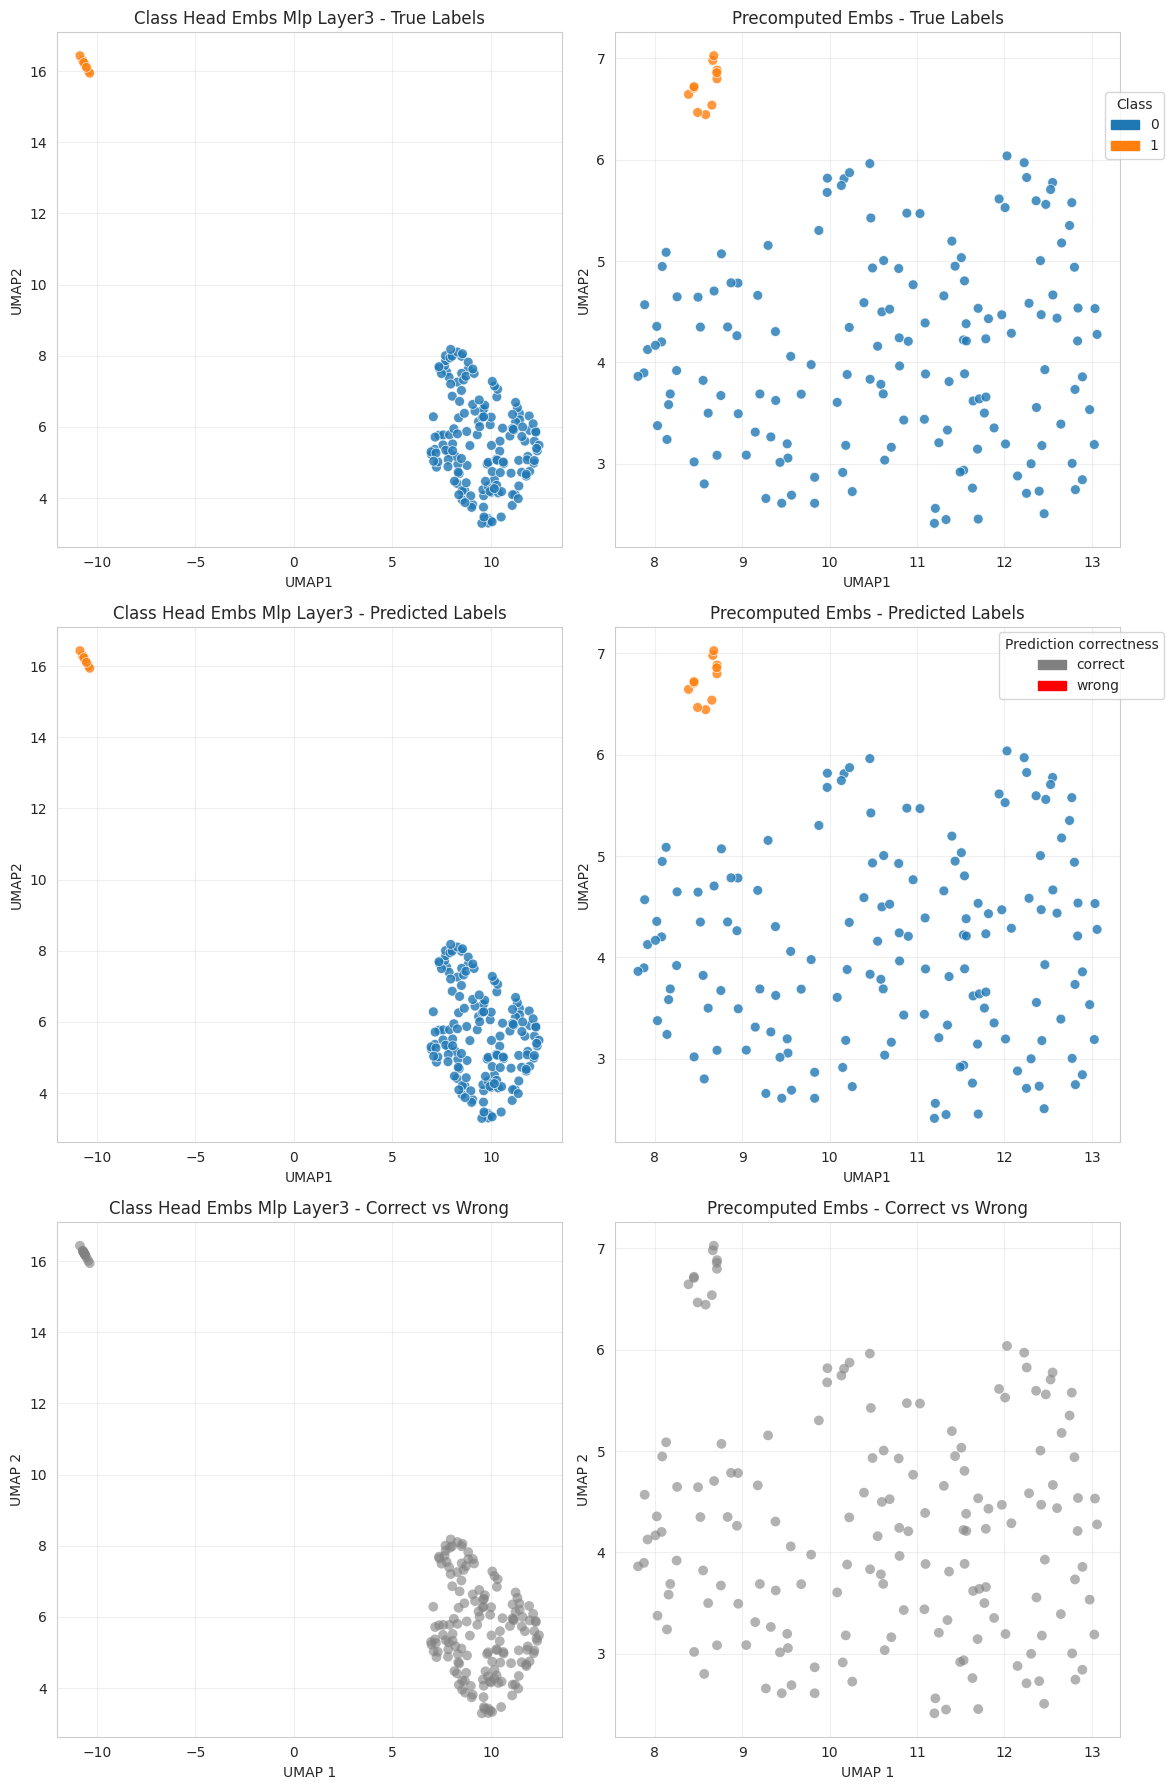

In [21]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors,
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=50,
        save_path = os.path.join(config["RESULTS_FOLDER_PATH"], "umap_test.pdf")
        )
else:
    print("No embs to plot")

In [22]:
train_embeddings["class_head_embs_mlp_layer3"]

array([[0.       , 0.       , 1.8610692, ..., 0.       , 1.2226794,
        0.       ],
       [0.       , 0.       , 1.8576472, ..., 0.       , 1.1347213,
        0.       ],
       [0.       , 0.       , 1.84493  , ..., 0.       , 1.1646197,
        0.       ],
       ...,
       [0.       , 0.       , 1.8485686, ..., 0.       , 1.1408029,
        0.       ],
       [0.       , 0.       , 1.8464729, ..., 0.       , 1.1155863,
        0.       ],
       [0.       , 0.       , 1.8489772, ..., 0.       , 1.1534863,
        0.       ]], dtype=float32)

In [23]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

# PCA on embs
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_embeddings["class_head_embs_mlp_layer3"])
print(pca.explained_variance_ratio_)


# wrong lablled
TP_df = df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")]
print(TP_df.Name.to_list())
display(TP_df)

FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

[9.97074664e-01 1.56916305e-03 5.05203556e-04 2.90285505e-04
 1.56936279e-04 1.11769798e-04 1.02442384e-04 6.82713144e-05
 5.80654741e-05 2.91255274e-05 1.86847647e-05 6.53243615e-06
 5.51980702e-06 1.77646211e-06 1.10144958e-06 3.27918002e-07
 3.46135736e-15 3.43495979e-15 3.43495979e-15 3.43495979e-15
 3.43495979e-15 3.43495979e-15 3.43495979e-15 3.43495979e-15
 3.43495979e-15 3.43495979e-15 3.43495979e-15 3.43495979e-15
 3.43495979e-15 3.43495979e-15 3.43495979e-15 3.23368338e-15]
['A0A2R8Y4L2', 'Q01130', 'Q13310', 'P38159', 'Q96E39', 'Q4VXU2', 'P0C7P1', 'P09651', 'P0DJD3', 'Q13151', 'P0CB38']


Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr
3    A0A2R8Y4L2  8.385872  6.646068         1         1    correct
37       Q01130  8.712365  6.885607         1         1    correct
58       Q13310  8.581960  6.446045         1         1    correct
62       P38159  8.663904  6.981507         1         1    correct
74       Q96E39  8.711328  6.799448         1         1    correct
130      Q4VXU2  8.652968  6.539695         1         1    correct
143      P0C7P1  8.709141  6.859638         1         1    correct
146      P09651  8.448005  6.708866         1         1    correct
147      P0DJD3  8.675250  7.027442         1         1    correct
149      Q13151  8.448822  6.721676         1         1    correct
157      P0CB38  8.490470  6.467333         1         1    correct

[]


Empty DataFrame
Columns: [Name, UMAP1, UMAP2, TrueClass, PredClass, CorrectStr]
Index: []


False Negatives
[]


Empty DataFrame
Columns: [Name, UMAP1, UMAP2, TrueClass, PredClass, CorrectStr]
Index: []

# A-scanning

In [24]:
# df_precomputed = df["precomputed_embs"].copy()
# train_correct = df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")]
# train_correct

# print(data[data.protein.isin(train_correct.Name)].sequence.apply(len).sort_values().head(10))

# data[data.label==1].iloc[284, :]

In [25]:
SUBSTITUTE_AA = ["A", "R", "E", "F"] #["inverse"]#["A", "R", "E", "F"]#["<mask>"] ["<pad>", "<unk>", "-", ".", "X"]
WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd

# Make folder to save
aa_scanning_folder_saving = os.path.join(
    os.path.dirname(config["PRECOMPUTED_EMBS_PATH"]),
    f"aa_scannining_mutations_ebs-aa_sub_[{'_'.join(SUBSTITUTE_AA)}]-window_{WINDOW_SIZE_SUBSTITUION}-model_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '_')}-emb_{config['TYPE_EMB_FOR_CLASSIFICATION']}")
if not os.path.exists(aa_scanning_folder_saving):
    os.makedirs(aa_scanning_folder_saving)
print(aa_scanning_folder_saving)

#PROTEINS = df_precomputed_train[(df_precomputed_train.CorrectStr == "correct") & (df_precomputed_train.TrueClass == "1")][:9].Name.to_list()
#PROTEINS = ['Q6XE38']#, 'O60575'] # for secreted
PROTEINS = [ 
            "P98179", #RMB
            "P31483", #TIA1
            "Q5JQF8", #common motif later
            "P52298",
            "P51991",
            "Q9BQ04",
            ]# for RNA binding
# PROTEINS = ["P17900"] # for lyso
# PROTEINS = ["P63167"
#             ] # for cc
# PROTEINS = [
#  'P06748', # has Nuclear localization signal
#  'Q07955', # speackle
#  'O76021',
#  'P62244',
#  'Q8NG66',
#  'Q8WTT2',
#  'Q96HI0',
#  'Q9BQ04',
#  'Q9H7Z3',
#  'Q9NW13',
#  #'P18583', #speakle
#  ] # for nucleolus


print(PROTEINS)

/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls
['P98179', 'P31483', 'Q5JQF8', 'P52298', 'P51991', 'Q9BQ04']


In [26]:
scan_result = {}

for i, P in enumerate(PROTEINS):

    print(i, "-->", P)

    ####################
    # Select single prot info

    idx = [cache_data["protein"].index(P)] # encapslu in a lsit
    selected_protein_data = my_dataset.subset_data_dict(cache_data, idx) #dict
    selected_prot_emb=selected_protein_data["embedding"]
    #print(selected_protein_data)

    ####################
    # create all mutatios

    all_mutated_seqs, mutation_names = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
    tot_mutations = len(all_mutated_seqs)
    print("Total mutations:", tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

    ####################
    # tokenize allmtuations

    # ATTNETION: alredy truncated
    print("Tokenizing...")
    encoded = tokenizer(
        all_mutated_seqs,
        padding='max_length',
        max_length=config["PROTEIN_MAX_LENGTH"],
        truncation=True,
        return_tensors="pt"
    )

    ####################
    # make cache data

    cache_mutations = {
        'protein': mutation_names,
        'sequence': all_mutated_seqs,
        'truncated_sequence': all_mutated_seqs, # alredy trucnated
        'input_ids': encoded["input_ids"],
        'attention_mask': encoded["attention_mask"],

        'embedding': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
        'label': torch.zeros(tot_mutations, dtype=torch.long), # FAKE
        'set': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
    }
    # display(cache_mutations["truncated_sequence"][:10])
    # print(np.asarray(cache_mutations["input_ids"][:10, :10]))

    ####################
    # Save mutations embs

    mutations_embs_path = os.path.join(
        aa_scanning_folder_saving,
        f"{P}.safetensors")
    mutations_names_path=mutations_embs_path.replace('.safetensors', '_names.json')

    if not os.path.exists(mutations_embs_path):
        my_dataset.create_uniprot_embs(
            esm_model=esm_model,
            config=config, 
            cache_data=cache_mutations, 
            num_samples=tot_mutations, 
            save_embs_path=mutations_embs_path,
            save_names_path=mutations_names_path,
            emb_dim=config["PRECOMPUTED_EMBS_DIM"]
        )

    embs_mutations, protein_names_selected = my_dataset.load_embs_safetensor(
        precomputed_embs_path=mutations_embs_path, # path with tensors
        protein_names_path=mutations_names_path, # path with the prtein names of the tenoser
        protein_to_select=None # take all
    )

    cache_mutations["embedding"] = embs_mutations

    #check
    print(protein_names_selected == cache_mutations["protein"])

    ####################
    # Make dataloder
    mutations_dl = my_dataset.create_dataloader(cache_mutations, config["BATCH_SIZE"], shuffle=False) 
    names_mutations = cache_mutations["protein"]


    ##############################
    # calcualte baseline prob

    wt_dl = my_dataset.create_dataloader(selected_protein_data, batch_size=1, shuffle=False) 
    wt_dict = mf.evaluate_model(
                net=net, 
                dl=wt_dl,
                device=config["DEVICE"], 
                loss_fn=net.loss_fn,
                split_name="WT prot", 
                verbose=False,
                from_precomputed_embs=True
            )
    baseline_prob = float(wt_dict["probs_class1"][0])
    print(baseline_prob)

    ##############################
    # calculate prob for each utation

    scan_results_tmp = my_scanning.multi_aa_scanning_tmp(
        model=net,
        baseline_prob=baseline_prob,
        mutations_dl=mutations_dl,
        names_mutations=names_mutations,
        substitute_aas=SUBSTITUTE_AA,
        wt_seq=selected_protein_data["truncated_sequence"][0],
        prot_name=P, 
        device=config["DEVICE"], 
    )

    scan_result[P] = scan_results_tmp

# Save results
aa_scanning_scan_result_path = os.path.join(
        aa_scanning_folder_saving,
        f"scan_results.json")
with open(aa_scanning_scan_result_path, 'w') as f:
    json.dump(scan_result, f, indent=4)

# Load data
with open(aa_scanning_scan_result_path, 'r') as f:
    # Use json.load() to deserialize the data from the file object 'f'
    scan_result = json.load(f)

clear_output(wait=True)

0 --> P98179


Generating mutations: 100%|██████████| 157/157 [00:00<00:00, 77892.80it/s]

Total mutations: 628 628
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/P98179.safetensors
✓ Mapped 628 embeddings (shape: torch.Size([628, 2560]))
✓ Loaded 628 / 628 embeddings
  Shape: torch.Size([628, 2560])
  Memory: 6.1 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9595716595649719


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/5 [00:00<?, ? mutations batch/s]

1 --> P31483


Generating mutations: 100%|██████████| 386/386 [00:00<00:00, 46452.28it/s]

Total mutations: 1544 1544
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/P31483.safetensors
✓ Mapped 1544 embeddings (shape: torch.Size([1544, 2560]))
✓ Loaded 1544 / 1544 embeddings
  Shape: torch.Size([1544, 2560])
  Memory: 15.1 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9595475196838379


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/13 [00:00<?, ? mutations batch/s]

2 --> Q5JQF8


Generating mutations: 100%|██████████| 200/200 [00:00<00:00, 71593.48it/s]

Total mutations: 800 800
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/Q5JQF8.safetensors
✓ Mapped 800 embeddings (shape: torch.Size([800, 2560]))
✓ Loaded 800 / 800 embeddings
  Shape: torch.Size([800, 2560])
  Memory: 7.8 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9595436453819275


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/7 [00:00<?, ? mutations batch/s]

3 --> P52298


Generating mutations: 100%|██████████| 156/156 [00:00<00:00, 90013.95it/s]

Total mutations: 624 624
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/P52298.safetensors
✓ Mapped 624 embeddings (shape: torch.Size([624, 2560]))
✓ Loaded 624 / 624 embeddings
  Shape: torch.Size([624, 2560])
  Memory: 6.1 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9594860672950745


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/5 [00:00<?, ? mutations batch/s]

4 --> P51991


Generating mutations: 100%|██████████| 378/378 [00:00<00:00, 47936.35it/s]

Total mutations: 1512 1512
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/P51991.safetensors
✓ Mapped 1512 embeddings (shape: torch.Size([1512, 2560]))
✓ Loaded 1512 / 1512 embeddings
  Shape: torch.Size([1512, 2560])
  Memory: 14.8 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9595962166786194


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/12 [00:00<?, ? mutations batch/s]

5 --> Q9BQ04


Generating mutations: 100%|██████████| 359/359 [00:00<00:00, 51983.54it/s]

Total mutations: 1436 1436
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/Q9BQ04.safetensors
✓ Mapped 1436 embeddings (shape: torch.Size([1436, 2560]))
✓ Loaded 1436 / 1436 embeddings
  Shape: torch.Size([1436, 2560])
  Memory: 14.0 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9597672820091248


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/12 [00:00<?, ? mutations batch/s]

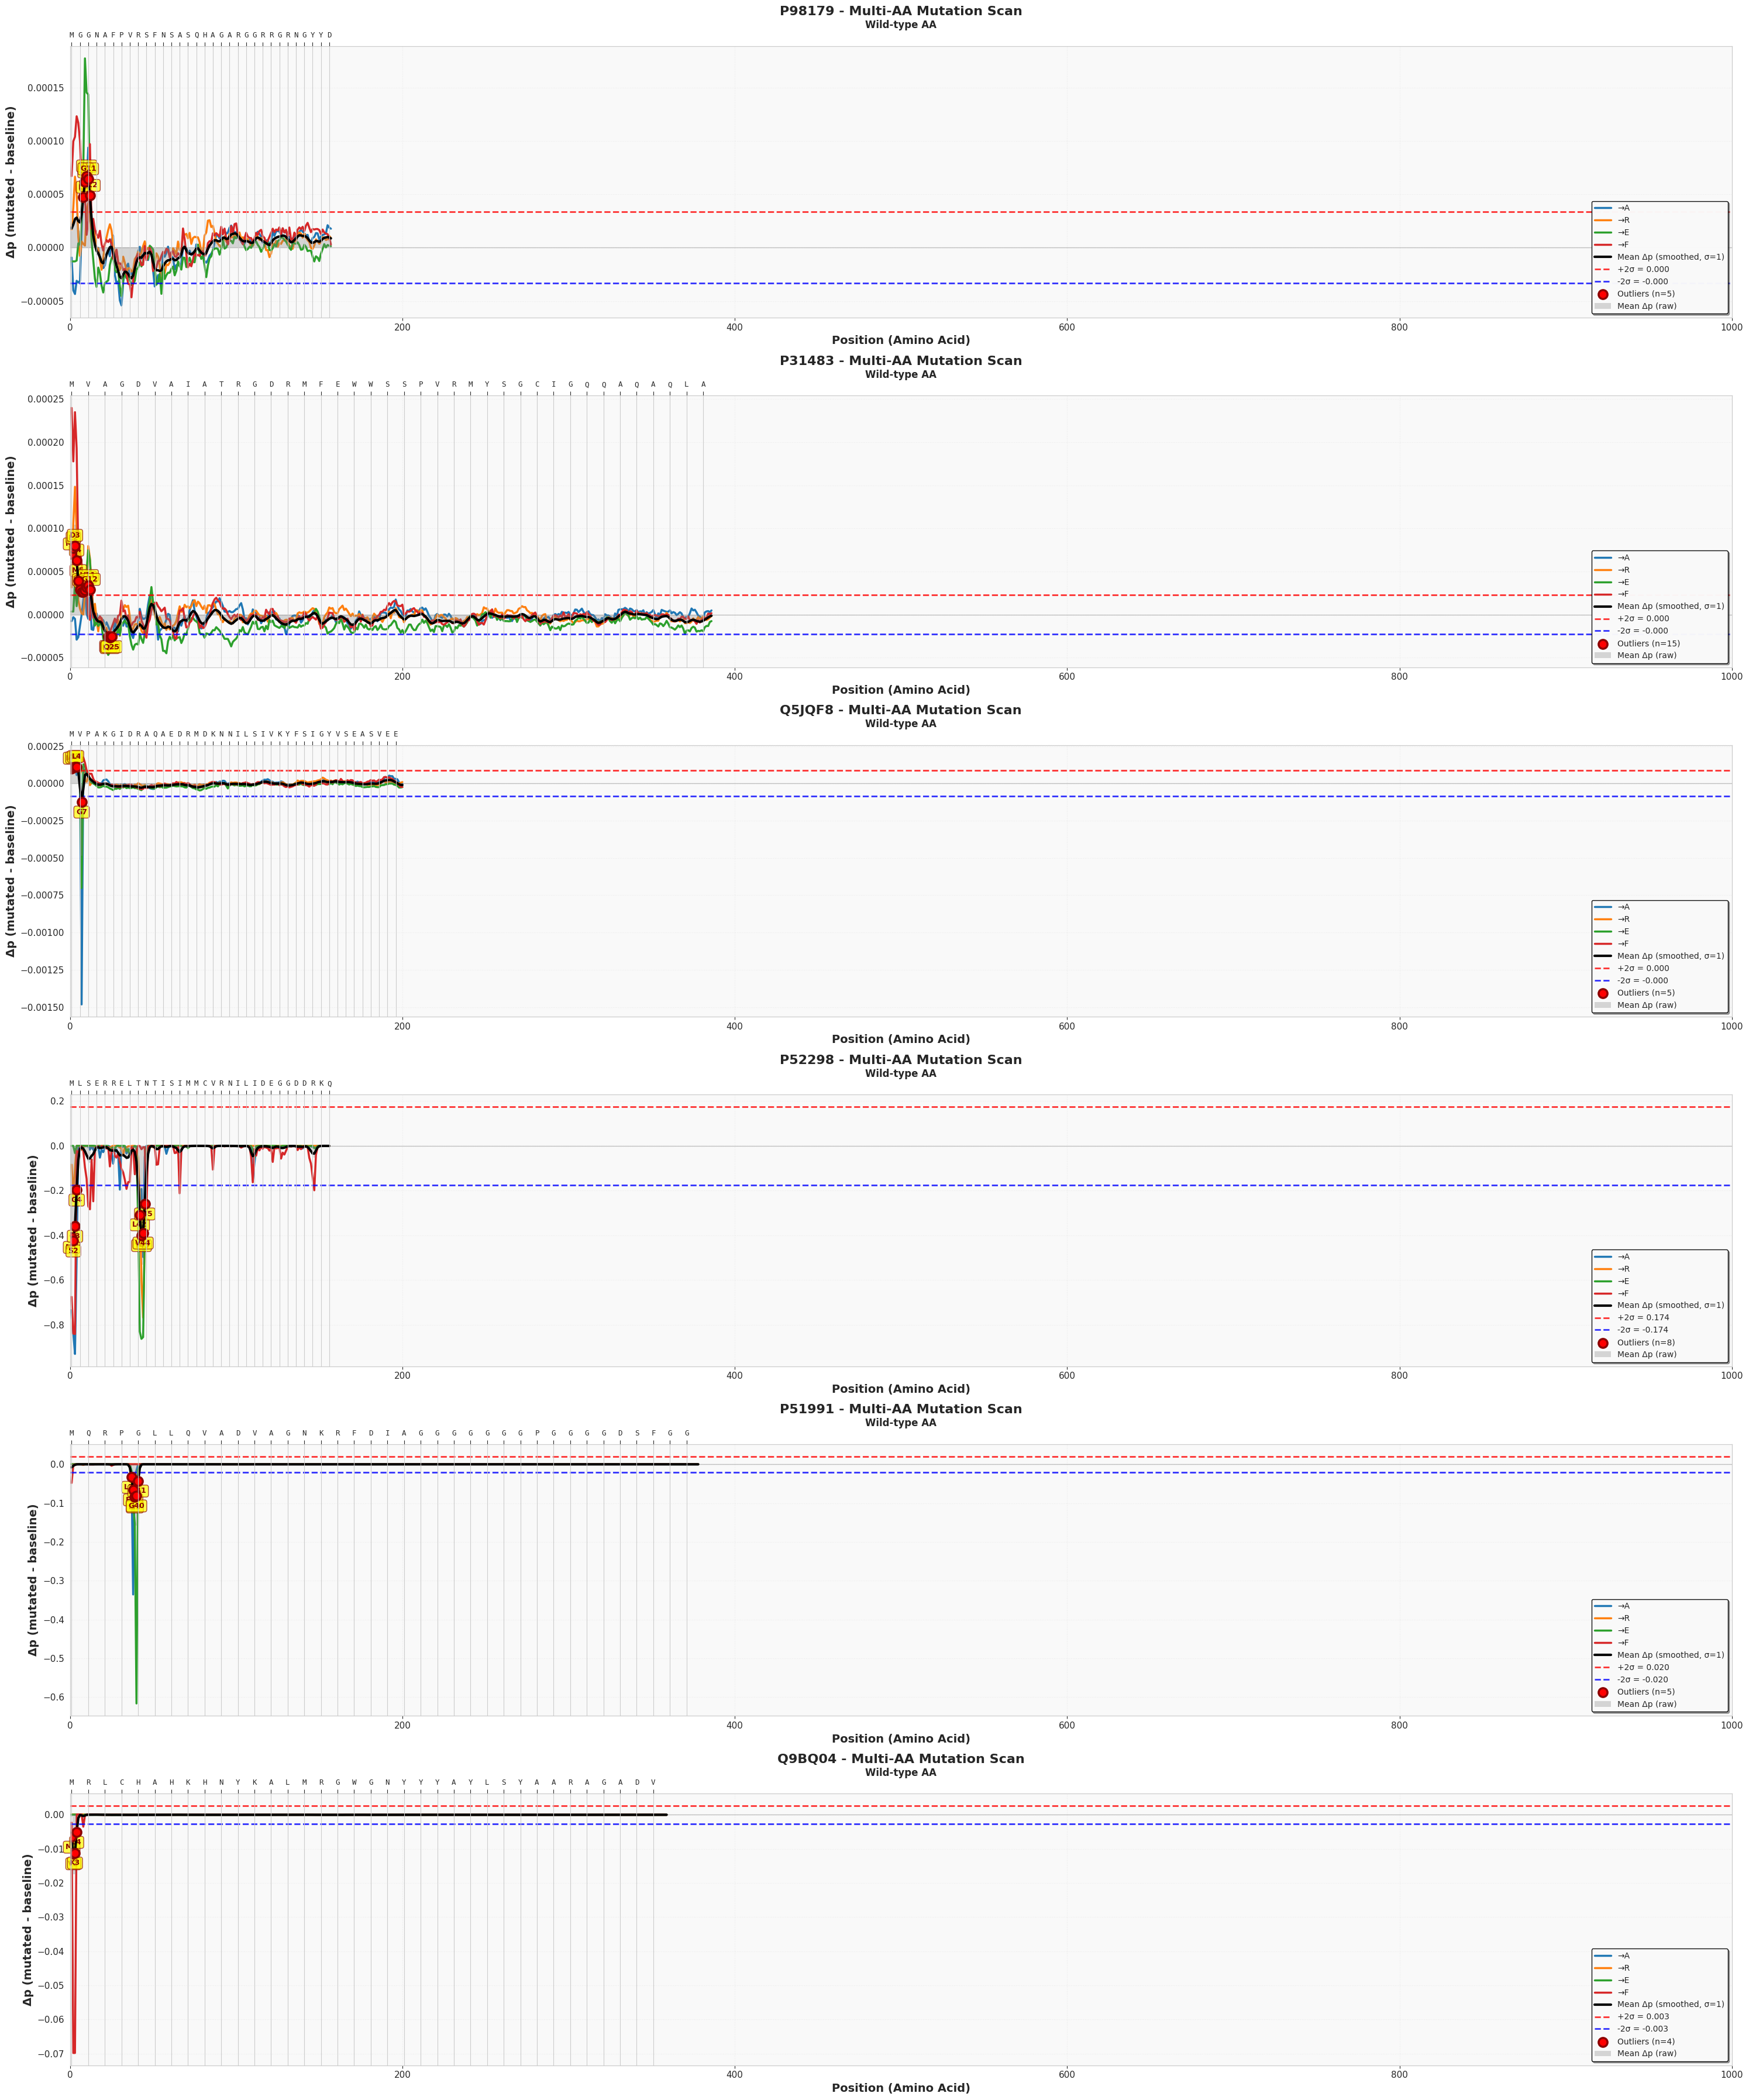

✅ Saved combined figure as all_proteins_scans.png


In [27]:
n = len(PROTEINS)
fig, axes = plt.subplots(n, 1, figsize=(30, 6 * n), sharex=False)

if n == 1:
    axes = [axes]  # make iterable

for ax, P in zip(axes, PROTEINS):
    my_scanning.plot_multi_aa_scan(
        scan_result[P],
        sigma=1,
        palette='RdBu_r',
        show_per_aa=True,
        xlim=[0, 1000], # common for all (even if a protein is shorter)
        ax=ax,  #  draw directly into subplot
        sub_aa_for_mean=None
    )
    ax.set_title(f"{P} - Multi-AA Mutation Scan", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(config["RESULTS_FOLDER_PATH"], "scanning.png"), dpi=300)
plt.show(fig)
print("✅ Saved combined figure as all_proteins_scans.png")

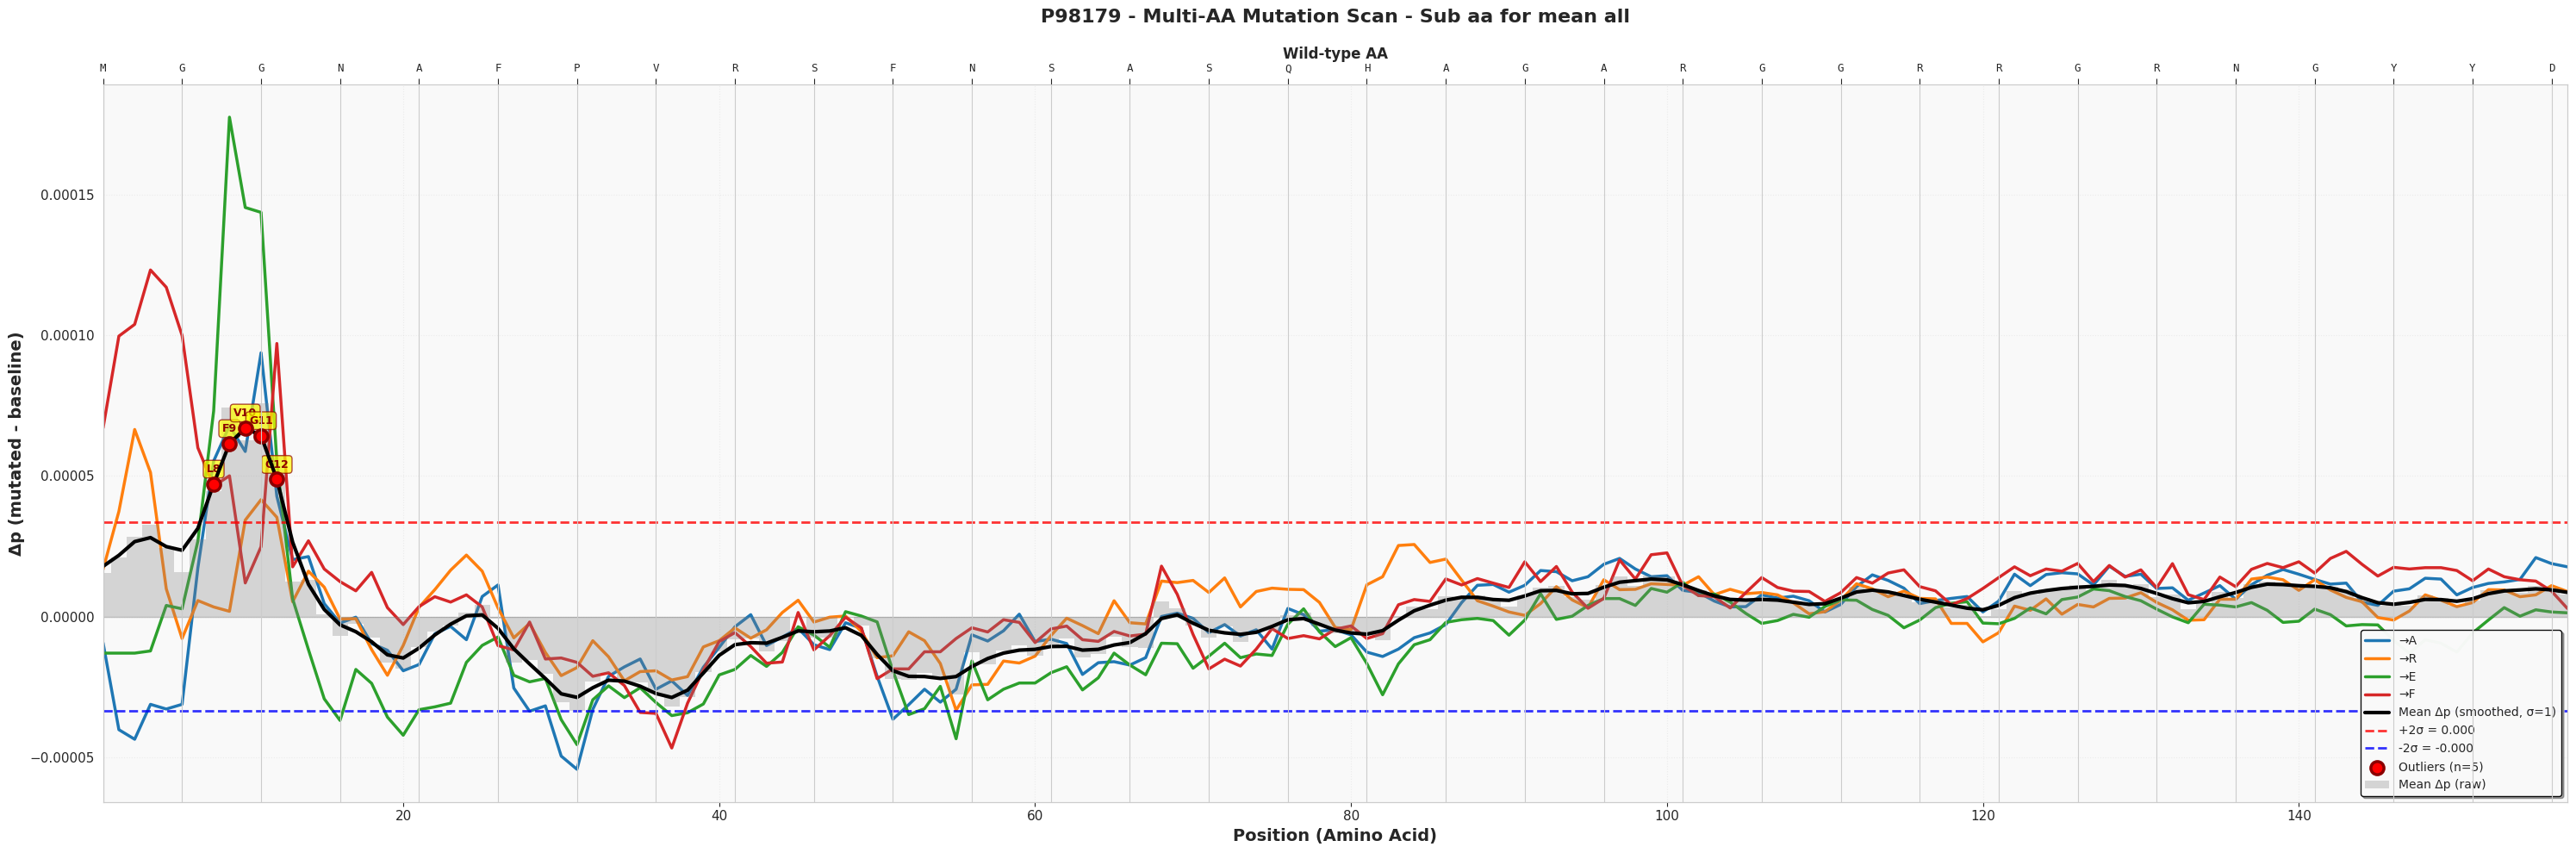

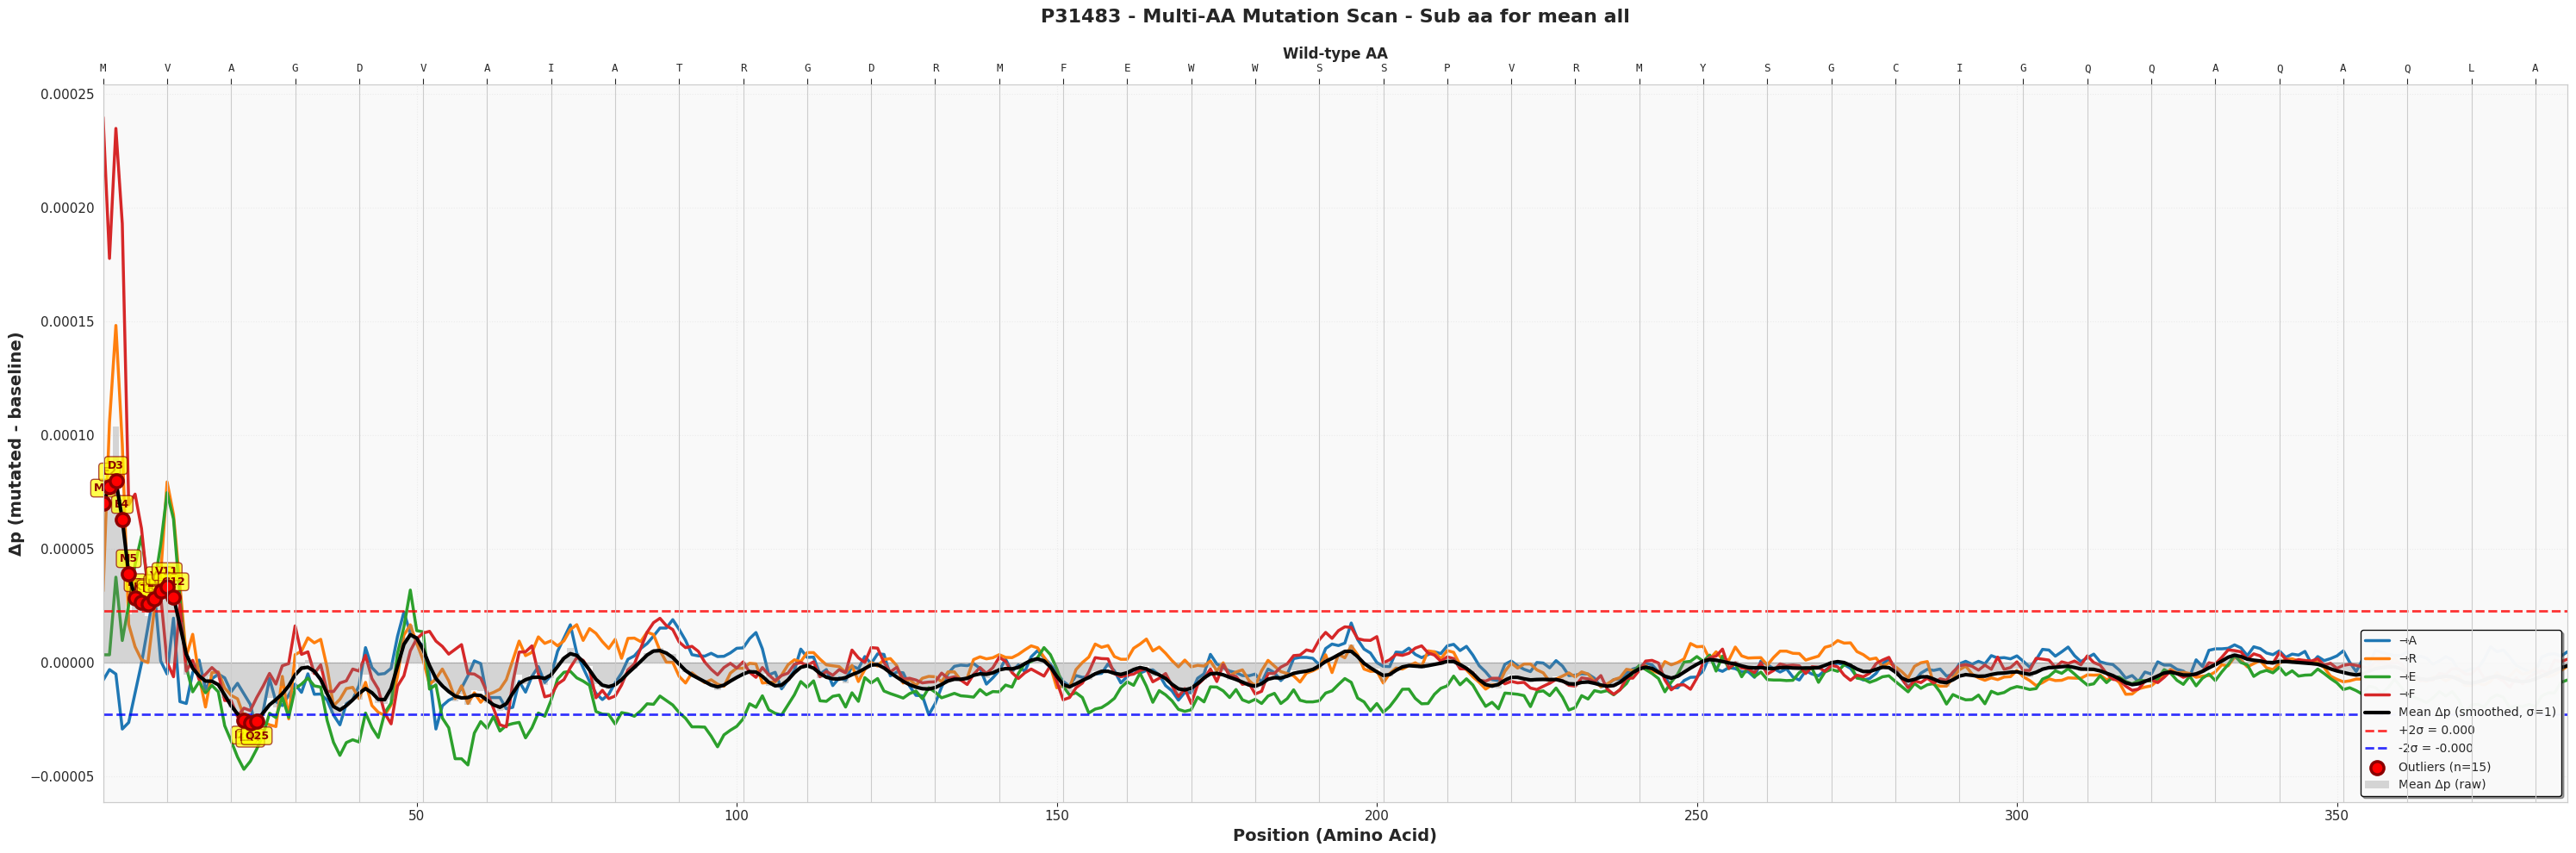

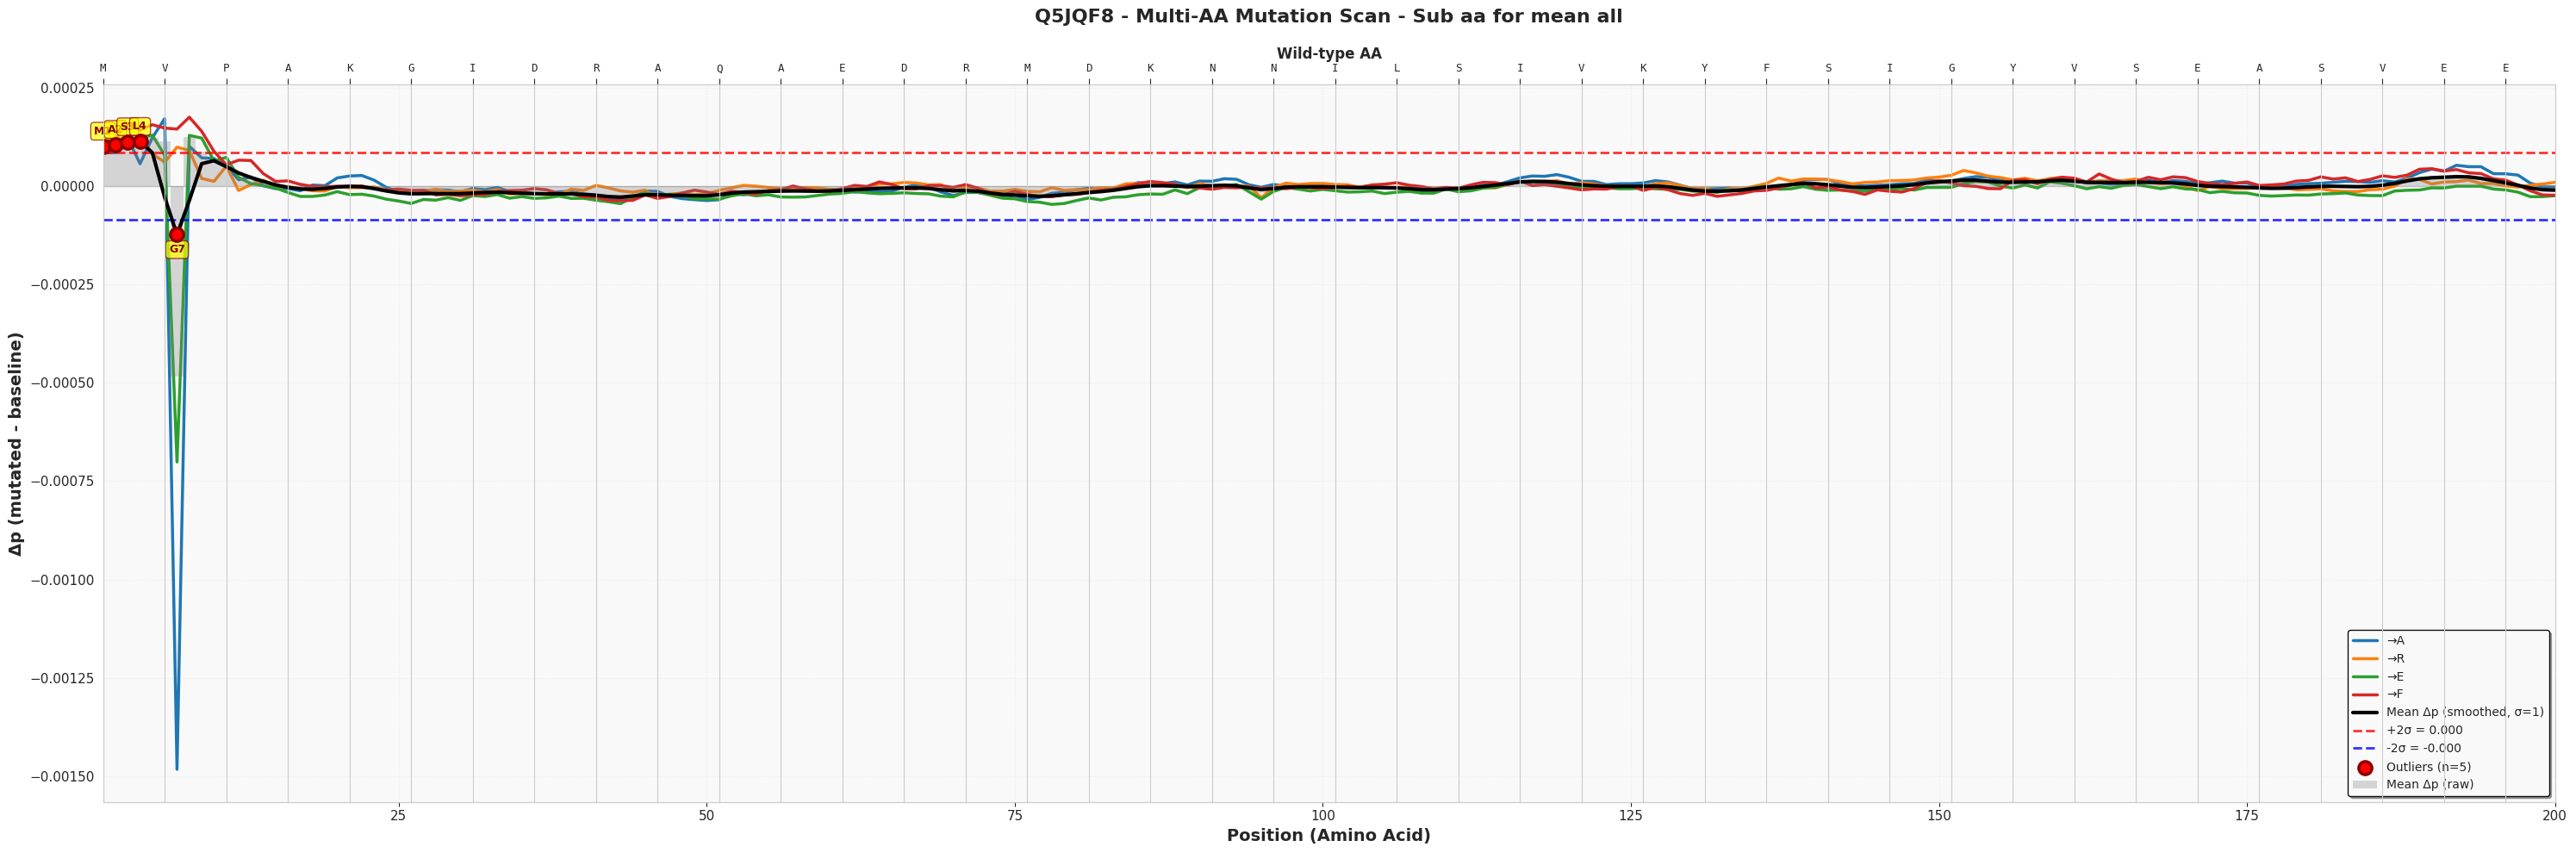

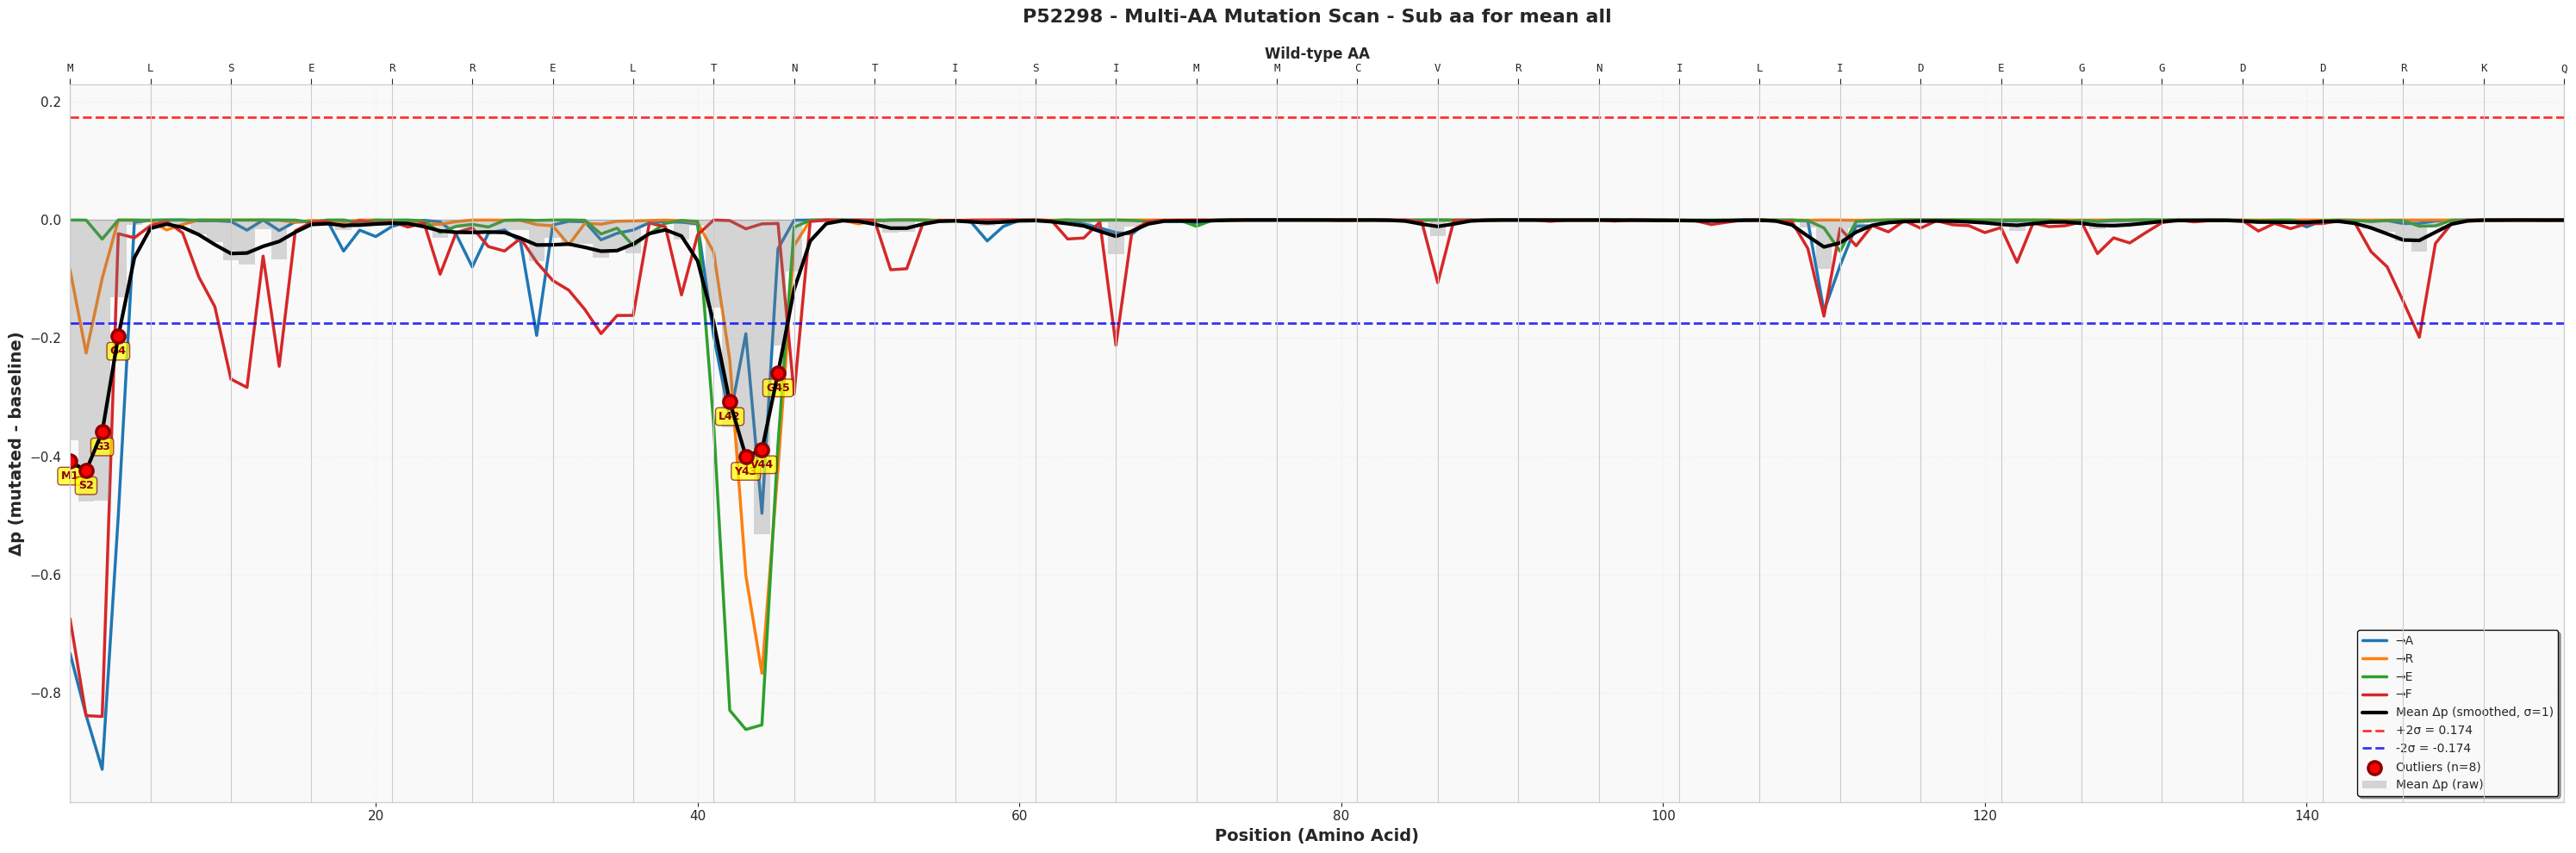

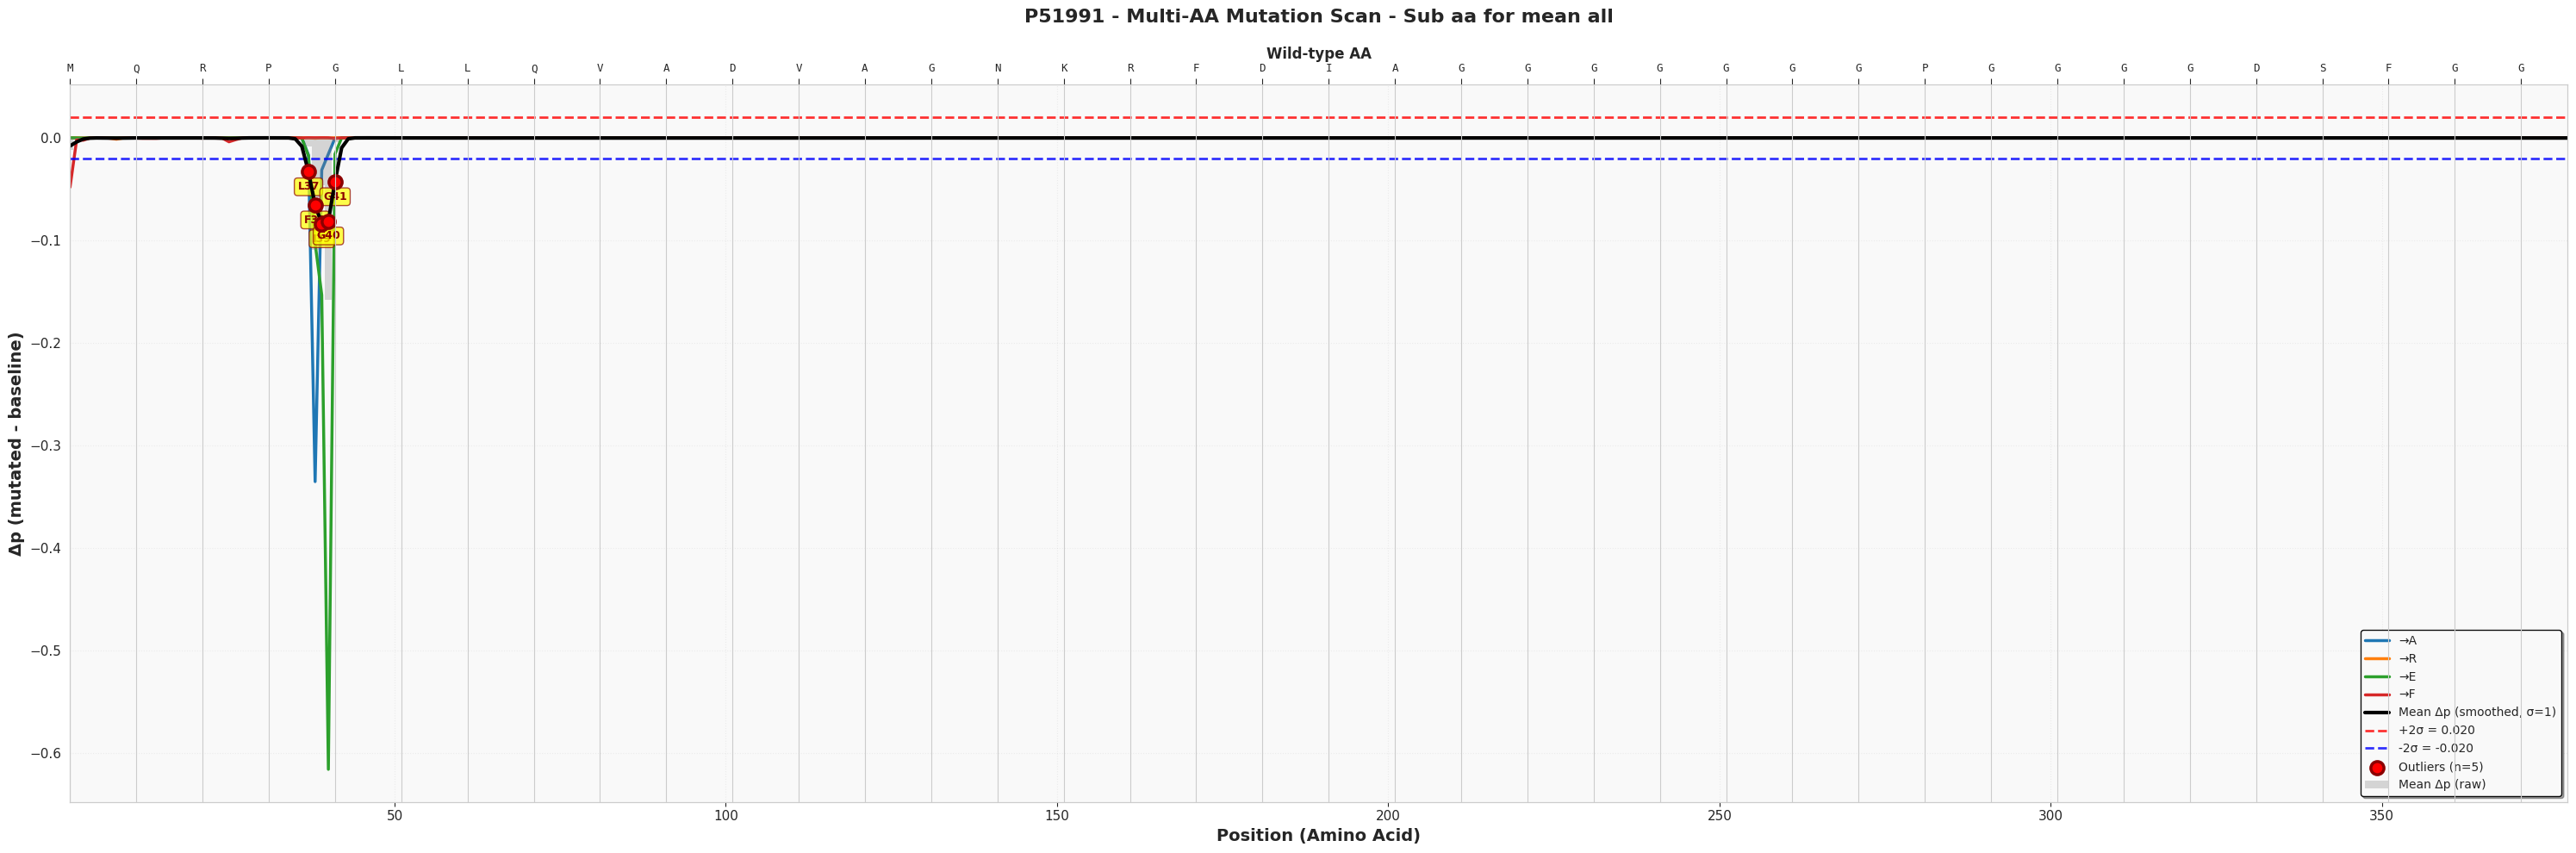

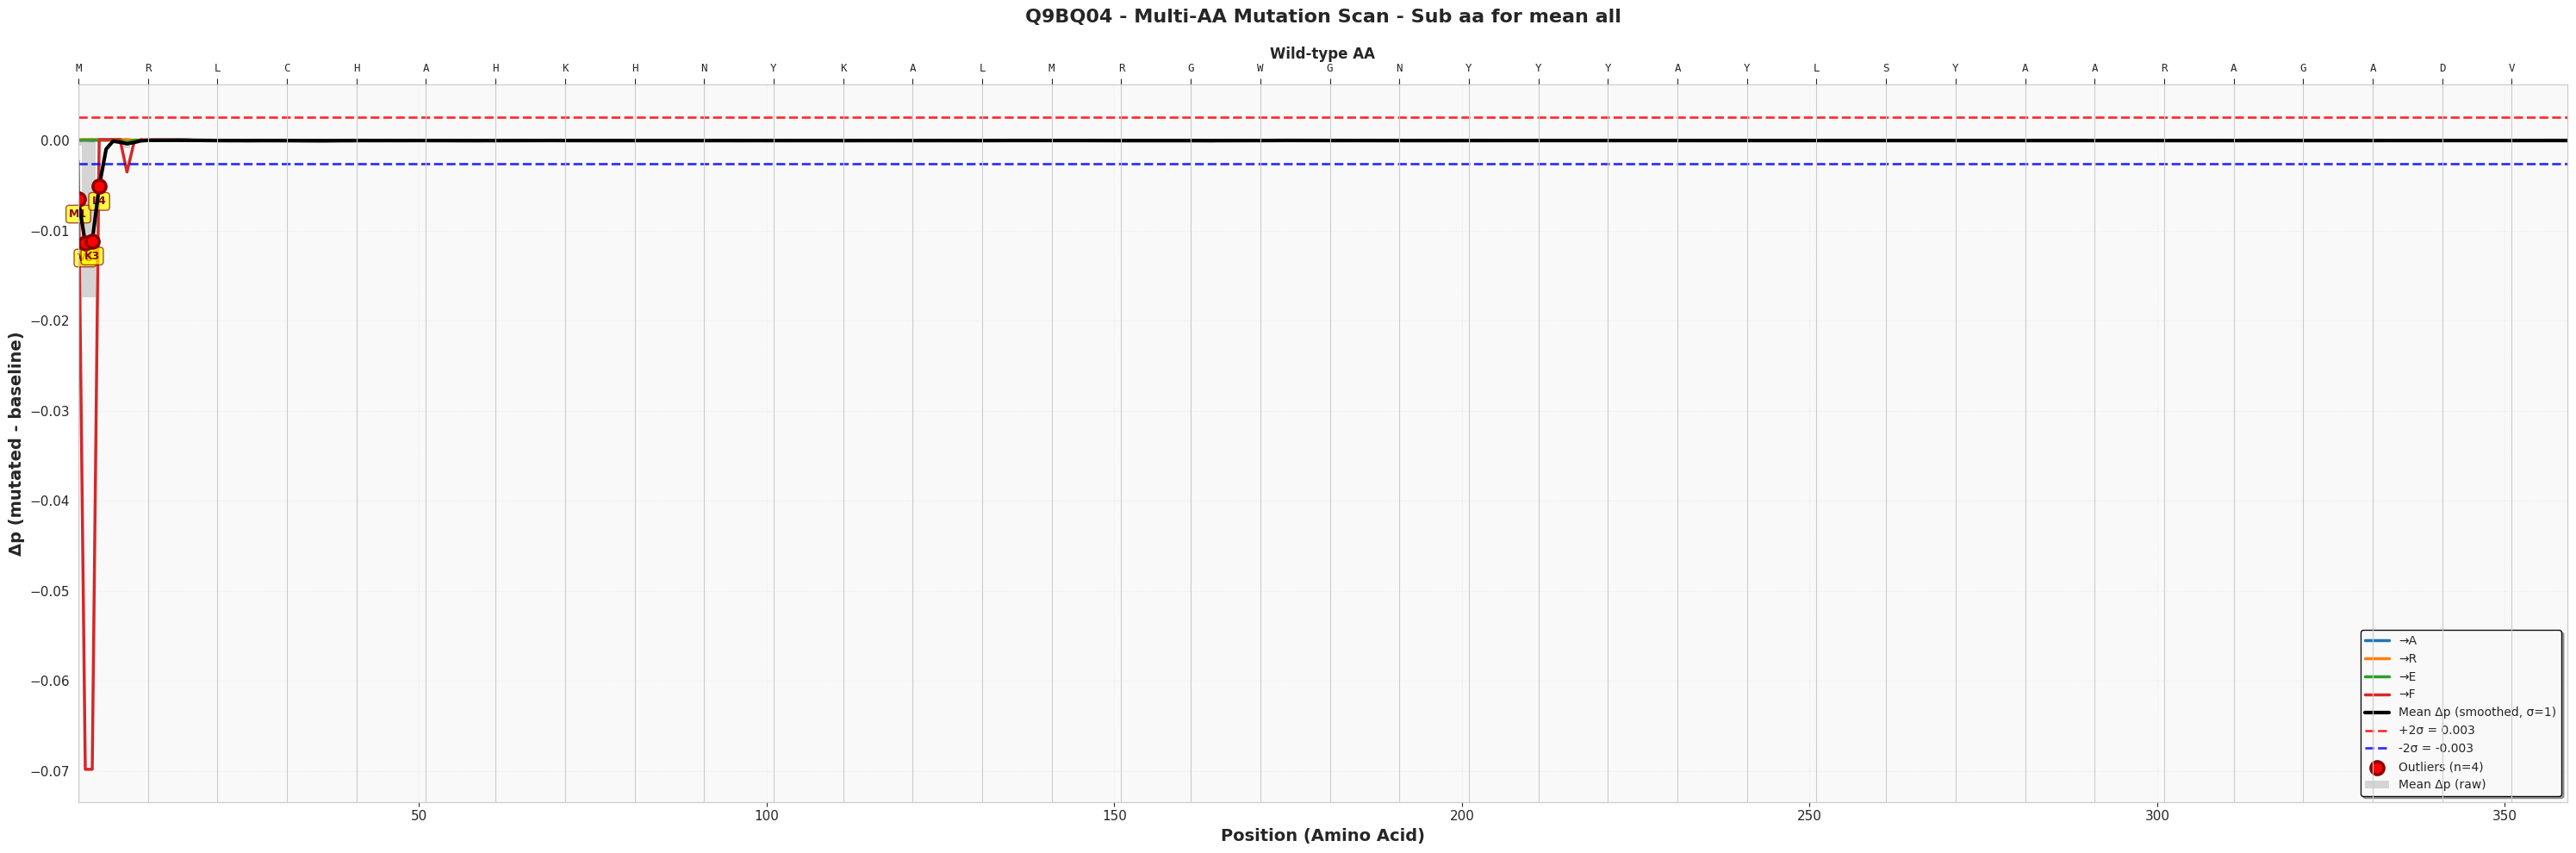

In [33]:
for P in PROTEINS:
    my_scanning.plot_multi_aa_scan(
                            scan_result[P], sigma=1,figsize=(30, 10), show_per_aa=True, ax=None,
                            #sub_aa_for_mean=["A", "R", "E", "F"]#,, "<unk>", "-", ".", "X"],#"A", "R", "E"], ["<pad>", "<unk>", "-", ".", "X"]
                            #, xlim=[0,1000]
                            )


In [29]:
stop

NameError: name 'stop' is not defined

# Plot mutations embs

In [30]:
P = PROTEINS[2]

print( P)

####################
# Select single prot info

idx = [cache_data["protein"].index(P)] # encapslu in a lsit
selected_protein_data = my_dataset.subset_data_dict(cache_data, idx) #dict
selected_prot_emb=selected_protein_data["embedding"]
#print(selected_protein_data)

####################
# create all mutatios

all_mutated_seqs, mutation_names = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_mutated_seqs)
print("Total mutations:", tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

####################
# tokenize allmtuations

# ATTNETION: alredy truncated
print("Tokenizing...")
encoded = tokenizer(
    all_mutated_seqs,
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)

####################
# make cache data

cache_mutations = {
    'protein': mutation_names,
    'sequence': all_mutated_seqs,
    'truncated_sequence': all_mutated_seqs, # alredy trucnated
    'input_ids': encoded["input_ids"],
    'attention_mask': encoded["attention_mask"],

    'embedding': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
    'label': torch.zeros(tot_mutations, dtype=torch.long), # FAKE
    'set': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
}
# display(cache_mutations["truncated_sequence"][:10])
# print(np.asarray(cache_mutations["input_ids"][:10, :10]))

####################
# Save mutations embs

mutations_embs_path = os.path.join(
    aa_scanning_folder_saving,
    f"{P}.safetensors")
mutations_names_path=mutations_embs_path.replace('.safetensors', '_names.json')

if not os.path.exists(mutations_embs_path):
    my_dataset.create_uniprot_embs(
        esm_model=esm_model,
        config=config, 
        cache_data=cache_mutations, 
        num_samples=tot_mutations, 
        save_embs_path=mutations_embs_path,
        save_names_path=mutations_names_path,
        emb_dim=config["PRECOMPUTED_EMBS_DIM"]
    )

embs_mutations, protein_names_selected = my_dataset.load_embs_safetensor(
    precomputed_embs_path=mutations_embs_path, # path with tensors
    protein_names_path=mutations_names_path, # path with the prtein names of the tenoser
    protein_to_select=None # take all
)

Q5JQF8


Generating mutations: 100%|██████████| 200/200 [00:00<00:00, 81284.96it/s]

Total mutations: 800 800
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/Q5JQF8.safetensors
✓ Mapped 800 embeddings (shape: torch.Size([800, 2560]))
✓ Loaded 800 / 800 embeddings
  Shape: torch.Size([800, 2560])
  Memory: 7.8 MB


In [31]:


import numpy as np
import pandas as pd
import umap

# ============================================================
# 1️⃣ UMAP fitted only on dataset
# ============================================================
umap_model_dataset = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_jobs=1
)

umap_model_dataset.fit(all_dataset_embs)

umap_dataset_all_dataset = umap_model_dataset.transform(all_dataset_embs)
umap_dataset_mutations = umap_model_dataset.transform(embs_mutations)
umap_dataset_selected = umap_model_dataset.transform(selected_prot_emb)

# ============================================================
# 2️⃣ UMAP fitted on all embeddings
# ============================================================
combined_embs = np.concatenate([all_dataset_embs, embs_mutations, selected_prot_emb], axis=0)

umap_model_all = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_jobs=1
)

umap_model_all.fit(combined_embs)

umap_all_dataset = umap_model_all.transform(all_dataset_embs)
umap_all_mutations = umap_model_all.transform(embs_mutations)
umap_all_selected = umap_model_all.transform(selected_prot_emb)

# ============================================================
# 3️⃣ Combine into one DataFrame
# ============================================================
df_dataset = pd.DataFrame({
    'Name': protein_names_selected_all_dataset,
    'Source': ['Dataset'] * len(protein_names_selected_all_dataset),
    'Position': [None] * len(protein_names_selected_all_dataset),
    'Sub_aa': [None] * len(protein_names_selected_all_dataset),
    'UMAP1_datasetOnly': umap_dataset_all_dataset[:, 0],
    'UMAP2_datasetOnly': umap_dataset_all_dataset[:, 1],
    'UMAP1_allData': umap_all_dataset[:, 0],
    'UMAP2_allData': umap_all_dataset[:, 1],
})

df_mutations = pd.DataFrame({
    'Name': protein_names_selected,
    'Source': ['Mutations'] * len(protein_names_selected),
    'Position': [int(n.split('_')[0]) for n in protein_names_selected],
    'Sub_aa': [n.split('_')[1] for n in protein_names_selected],
    'UMAP1_datasetOnly': umap_dataset_mutations[:, 0],
    'UMAP2_datasetOnly': umap_dataset_mutations[:, 1],
    'UMAP1_allData': umap_all_mutations[:, 0],
    'UMAP2_allData': umap_all_mutations[:, 1],
})

df_selected = pd.DataFrame({
    'Name': [P],
    'Source': ['Selected'],
    'Position': [None],
    'Sub_aa': [None],
    'UMAP1_datasetOnly': umap_dataset_selected[:, 0],
    'UMAP2_datasetOnly': umap_dataset_selected[:, 1],
    'UMAP1_allData': umap_all_selected[:, 0],
    'UMAP2_allData': umap_all_selected[:, 1],
})

# Combine all
df_umap_combined = pd.concat([df_dataset, df_mutations, df_selected], ignore_index=True)

df_umap_combined.head()


Name   Source Position Sub_aa  UMAP1_datasetOnly  UMAP2_datasetOnly  \
0  A6NDE4  Dataset     None   None          14.494720           7.561404   
1  O00425  Dataset     None   None          13.310208           6.677763   
2  O75494  Dataset     None   None          13.850004           7.145424   
3  P09651  Dataset     None   None          14.073966           6.540515   
4  P0DJD3  Dataset     None   None          14.498841           7.521226   

   UMAP1_allData  UMAP2_allData  
0      -2.370284      -3.807824  
1       4.798532      -1.140050  
2      -2.821454      -3.675126  
3      -3.123092      -4.075610  
4      -2.430578      -3.785316

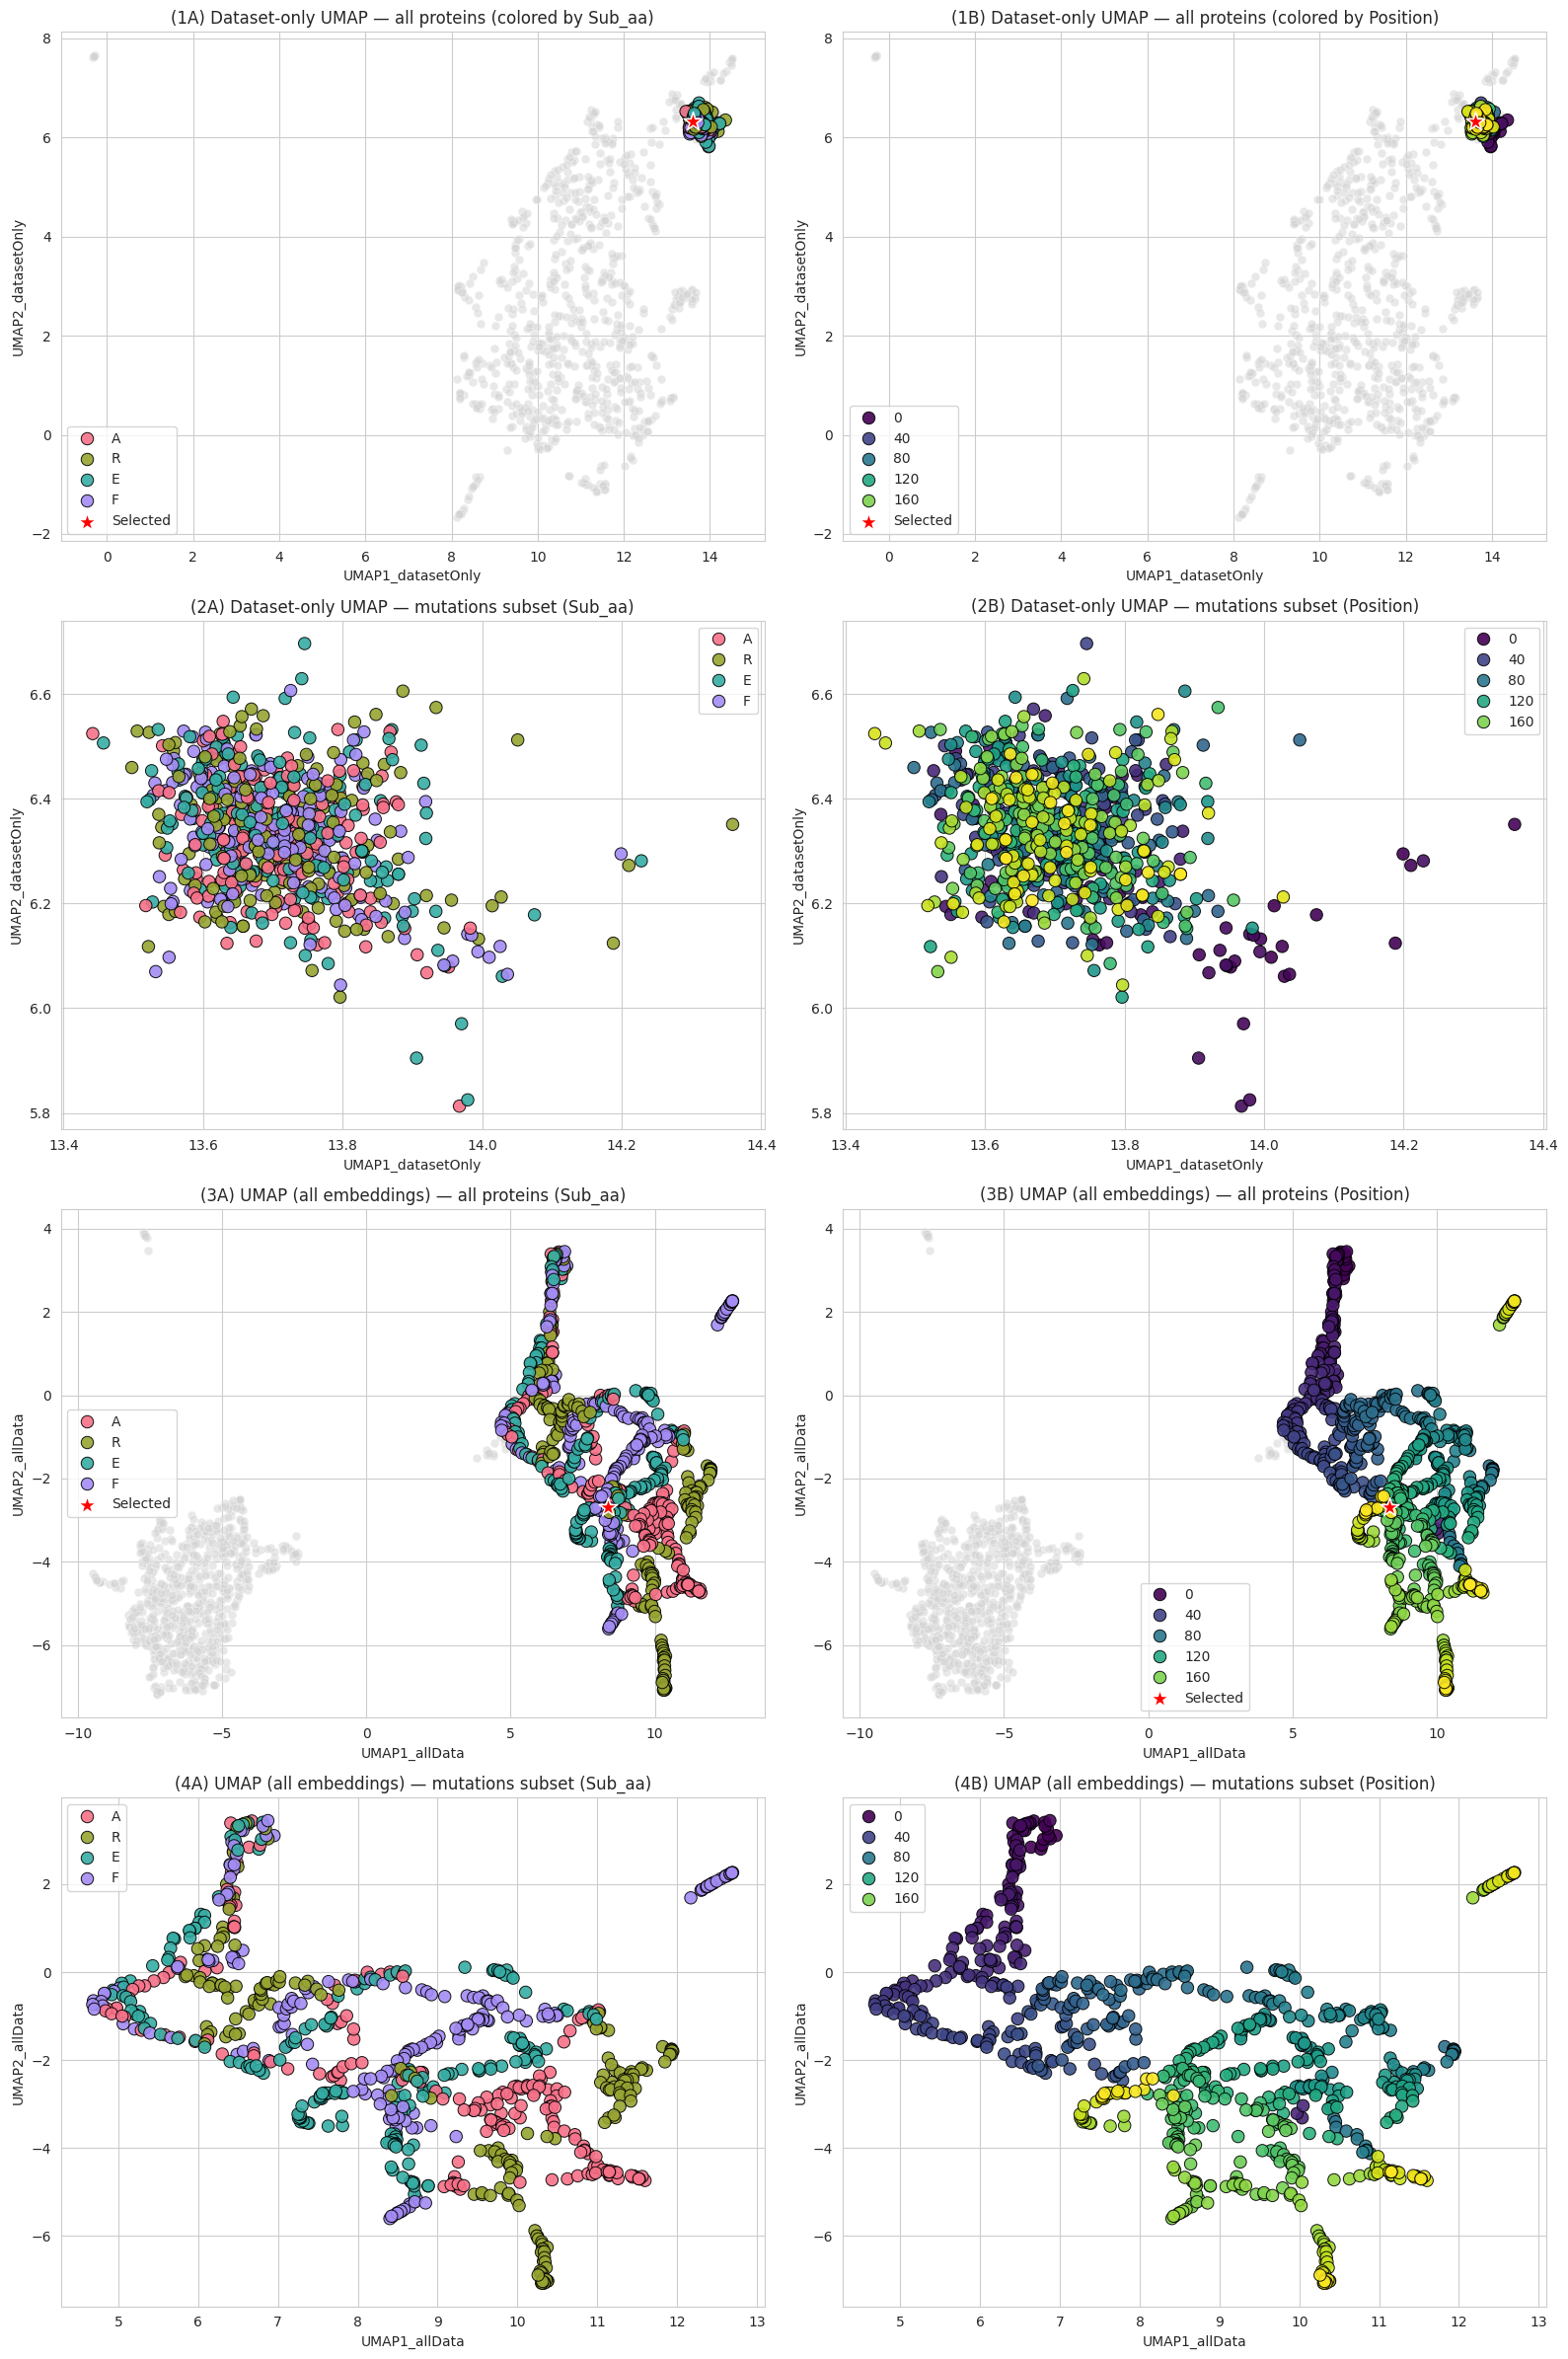

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# General figure setup
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Helper plotting function
def plot_umap(ax, df, x, y, hue, title, palette, show_dataset_bg=True):
    # Optional gray background for dataset
    if show_dataset_bg:
        sns.scatterplot(
            data=df[df["Source"] == "Dataset"],
            x=x, y=y,
            color="lightgrey", s=40, alpha=0.5, ax=ax, label=None
        )
    # Colored scatter
    sns.scatterplot(
        data=df[df["Source"] == "Mutations"],
        x=x, y=y,
        hue=hue,
        palette=palette,
        s=80, alpha=0.9,
        edgecolor="black", ax=ax
    )
    # Highlight selected protein
    sns.scatterplot(
        data=df[df["Source"] == "Selected"],
        x=x, y=y,
        color="red", marker="*", s=200, ax=ax, label="Selected"
    )
    ax.set_title(title, fontsize=12)
    ax.legend(loc="best")

# --------------------------------------------------------
# Row 1: UMAP fit only on dataset (all proteins)
# --------------------------------------------------------
plot_umap(
    axes[0, 0], df_umap_combined,
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Sub_aa", title="(1A) Dataset-only UMAP — all proteins (colored by Sub_aa)",
    palette="husl"
)
plot_umap(
    axes[0, 1], df_umap_combined,
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Position", title="(1B) Dataset-only UMAP — all proteins (colored by Position)",
    palette="viridis"
)

# --------------------------------------------------------
# Row 2: UMAP fit only on dataset (subset: only mutated proteins)
# --------------------------------------------------------
plot_umap(
    axes[1, 0], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Sub_aa", title="(2A) Dataset-only UMAP — mutations subset (Sub_aa)",
    palette="husl", show_dataset_bg=False
)
plot_umap(
    axes[1, 1], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Position", title="(2B) Dataset-only UMAP — mutations subset (Position)",
    palette="viridis", show_dataset_bg=False
)

# --------------------------------------------------------
# Row 3: UMAP fit on all embeddings (all proteins)
# --------------------------------------------------------
plot_umap(
    axes[2, 0], df_umap_combined,
    "UMAP1_allData", "UMAP2_allData",
    hue="Sub_aa", title="(3A) UMAP (all embeddings) — all proteins (Sub_aa)",
    palette="husl"
)
plot_umap(
    axes[2, 1], df_umap_combined,
    "UMAP1_allData", "UMAP2_allData",
    hue="Position", title="(3B) UMAP (all embeddings) — all proteins (Position)",
    palette="viridis"
)

# --------------------------------------------------------
# Row 4: UMAP fit on all embeddings (subset: only mutated proteins)
# --------------------------------------------------------
plot_umap(
    axes[3, 0], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_allData", "UMAP2_allData",
    hue="Sub_aa", title="(4A) UMAP (all embeddings) — mutations subset (Sub_aa)",
    palette="husl", show_dataset_bg=False
)
plot_umap(
    axes[3, 1], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_allData", "UMAP2_allData",
    hue="Position", title="(4B) UMAP (all embeddings) — mutations subset (Position)",
    palette="viridis", show_dataset_bg=False
)

plt.tight_layout()
plt.show()


In [ ]:
print(embs_mutations[:5])


tensor([[-0.0292, -0.0237, -0.1244,  ...,  0.1501, -0.0338, -0.1083],
        [-0.0238, -0.0269, -0.1215,  ...,  0.1901, -0.0261, -0.1104],
        [-0.0251, -0.0285, -0.1353,  ...,  0.1467, -0.0395, -0.1039],
        [-0.0608, -0.0466, -0.1225,  ...,  0.1736, -0.0294, -0.1078],
        [-0.0363, -0.0282, -0.1210,  ...,  0.1560, -0.0309, -0.1083]])


# Positional Bias?

### Generete possible variable sequences

In [ ]:
import os
import torch
import random
import warnings

def generate_positional_bias_tests(wt_seq, max_length=1000):
    """Generate artificial sequences for positional bias testing."""
    tests = {}
    # 1️⃣ Shuffle
    shuffled = list(wt_seq)
    random.shuffle(shuffled)
    tests["shuffle"] = "".join(shuffled)
    # 2️⃣ Reverse
    tests["reverse"] = wt_seq[::-1]
    # 3️⃣ Pad left (simulate left padding)
    pad_token = '<pad>'
    n_pad = min(50, len(wt_seq)//4)
    tests["pad_left"] = (pad_token * n_pad + wt_seq)[:max_length] # still truncate 
    # 4️⃣ Mask N-terminal residues
    masked = list(wt_seq)
    for i in range(min(50, len(masked))):
        masked[i] = "<mask>"
    tests["mask_N"] = "".join(masked)
    # 5️⃣ Random protein
    aas = list("MDVRTKKFCSYWGSDCFKRTFFTRRFGSNYICDMKKFGVFELAMDRWHRWWQNDVHWTQVEPVRFHDRAAQFKVQQLCRGQRMEWMEYGYRDSNVFFDKPITYEAYFEMYVHEATIHFCMKYQSCHTQFLDGRSWCQQHSHLLNYKQGQANQHQCTQCYFFHVAAEVPANDKPKSTMWINEPSSFWWDGSVGHGNTMRVRIQIQAQIFQANCPMDYQVNVHFQDRGVRSHLLERHDTDANEKYVGAVLNVCTCEEDWRQKSHDWWQDTQEQFCAYQLQFFAGNFYGHNKDRSYKANYWDMTWEVFVDVVFVMWDYGTGREFLDHRFHTCPQEDPDMRDNRPSGGGKHGNNHKPIVATADP")
    tests["random"] = "".join(random.choices(aas, k=len(wt_seq)))
    # 6️⃣ Center crop
    if len(wt_seq) > max_length:
        start = (len(wt_seq) - max_length) // 2
        end = start + max_length
        tests["center_crop"] = wt_seq[start:end]
    else:
        tests["center_crop"] = wt_seq
    # 6️⃣ Duplciate satrt at the end
    n = min(50, len(wt_seq)//4)
    tests["repeat_start"] =  ("MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA" + wt_seq + wt_seq[:n])[:max_length] # still truncate 
    return tests


# =============================
# Generate positional-bias test data
# =============================

print("🔹 Generating positional-bias test sequences...")

wt_seq = selected_protein_data["sequence"][0]
max_len = config["PROTEIN_MAX_LENGTH"]

bias_tests = generate_positional_bias_tests(wt_seq, max_length=max_len)
test_names = list(bias_tests.keys())
test_seqs = list(bias_tests.values())

for k, v in bias_tests.items():
    print(k, "-->", v)

# =============================
# Tokenize
# =============================
print("🔹 Tokenizing test sequences...")

encoded = tokenizer(
    test_seqs,
    padding='max_length',
    max_length=max_len,
    truncation=True,
    return_tensors="pt",
)

# =============================
# Prepare cache dict
# =============================
cache_bias = {
    'protein': test_names,
    'sequence': test_seqs,
    'truncated_sequence': test_seqs,
    'input_ids': encoded["input_ids"],
    'attention_mask': encoded["attention_mask"],
    'embedding': torch.zeros((len(test_seqs), 1), dtype=torch.float32),
    'label': torch.zeros(len(test_seqs), dtype=torch.long),
    'set': torch.zeros((len(test_seqs), 1), dtype=torch.float32),
}

# =============================
# Compute embeddings (using your ESM model)
# =============================

print("🔹 Creating embeddings for bias test sequences...")
out = my_dataset.create_uniprot_embs(
    esm_model=esm_model,
    config=config,
    cache_data=cache_bias,
    num_samples=len(test_seqs),
    emb_dim=config["PRECOMPUTED_EMBS_DIM"]
)

# =============================
# Load embeddings and dataloader
# =============================

embs_bias, bias_names_loaded = out["embs"], out["protein_names"]

cache_bias["embedding"] = embs_bias



🔹 Generating positional-bias test sequences...
shuffle --> KKFAACMAVIDVHNKATLCASREANKLKHAVAPLLLQLYDVVVPCLPSVLLIQSKLMLPLSKKEAFCEARWVALSLQSTFSCW
reverse --> KWWSKKLSLRKKFSIQDTCHKVELKAALAEPPPNLKAVQLNVAADSLFLFVTIESAVAPCVLAHAQYCCLALSVMLLCVSLRM
pad_left --> <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQVAKLNPPPEALAAKLEVKHCTDQISFKKRLSLKKSWWK
mask_N --> <mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask>PPPEALAAKLEVKHCTDQISFKKRLSLKKSWWK
random --> QQTLIVVFMWAFQRGADLPEFGIVNHNRPSDFFGGQTQDVNFTKAGFLEQAGGVEFCDELVHYNAVMHFDTMVFTPISRAQWK
center_crop --> MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQVAKLNPPPEALAAKLEVKHCTDQISFKKRLSLKKSWWK
repeat_start --> MAAAAAA

Processing protein batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing protein batches:   0%|          | 0/1 [00:13<?, ?it/s]


KeyboardInterrupt: 

### Reverse order

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
####################
# Select single biased prot info

selected_bias_cache = my_dataset.subset_data_dict(cache_bias, [6]) # 1 --> reverse
selected_bias_emb=selected_bias_cache["embedding"]
type_bias=selected_bias_cache["protein"][0]
print(type_bias)
print(selected_bias_cache.keys())

####################
# create all mutatios

all_biased_mutated_seqs, biased_mutation_names = my_scanning.create_all_mutations(selected_bias_cache["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_biased_mutated_seqs)
print(tot_mutations,  len(list(selected_bias_cache["truncated_sequence"][0])) * len(SUBSTITUTE_AA))
print(all_biased_mutated_seqs[:1])

####################
# tokenize allmtuations

# ATTNETION: alredy truncated
print("Tokenizing...")
encoded = tokenizer(
    all_biased_mutated_seqs,
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)

####################
# make cache data

cache_mutations_biased = {
    'protein': biased_mutation_names,
    'sequence': all_biased_mutated_seqs,
    'truncated_sequence': all_biased_mutated_seqs, # alredy trucnated
    'input_ids': encoded["input_ids"],
    'attention_mask': encoded["attention_mask"],

    'embedding': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
    'label': torch.zeros(tot_mutations, dtype=torch.long), # FAKE
    'set': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
}
display(cache_mutations_biased["truncated_sequence"][:10])
print(np.array(cache_mutations_biased["input_ids"][:10, :10]))

####################
# Save mutations embs

biased_mutations_embs_path = os.path.join(
    os.path.dirname(config["PRECOMPUTED_EMBS_PATH"]),
    "single_prot_mutations",
    f"{PROTEIN}_biased_{type_bias}_[{'_'.join(SUBSTITUTE_AA)}]_{WINDOW_SIZE_SUBSTITUION}_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
biased_mutations_names_path=biased_mutations_embs_path.replace('.safetensors', '_names.json')

if not os.path.exists(biased_mutations_embs_path):
    my_dataset.create_uniprot_embs(
        esm_model=esm_model,
        config=config, 
        cache_data=cache_mutations_biased, 
        num_samples=tot_mutations, 
        save_embs_path=biased_mutations_embs_path,
        save_names_path=biased_mutations_names_path,
        emb_dim=config["PRECOMPUTED_EMBS_DIM"]
    )

embs_biased_mutations, protein_biased_names_selected = my_dataset.load_embs_safetensor(
    precomputed_embs_path=biased_mutations_embs_path, # path with tensors
    protein_names_path=biased_mutations_names_path, # path with the prtein names of the tenoser
    protein_to_select=None # take all
)

cache_mutations_biased["embedding"] = embs_biased_mutations

#check
print(protein_biased_names_selected == cache_mutations_biased["protein"])

####################
# Make dataloder
mutations_dl_biased = my_dataset.create_dataloader(cache_mutations_biased, config["BATCH_SIZE"], shuffle=False) 
names_mutations_biased = cache_mutations_biased["protein"]


repeat_start
dict_keys(['protein', 'label', 'set', 'sequence', 'truncated_sequence', 'input_ids', 'attention_mask', 'embedding'])


Generating mutations: 100%|██████████| 263/263 [00:00<00:00, 45138.80it/s]

1315 1315
['<pad><pad><pad>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK']
Tokenizing...


['<pad><pad><pad>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '<unk><unk><unk>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '---AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '...AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSY

/tmp/ipykernel_542940/989421936.py:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(cache_mutations_biased["input_ids"][:10, :10]))


[[ 0  1  1  1  5  5  5  5  5  5]
 [ 0  3  3  3  5  5  5  5  5  5]
 [ 0 30 30 30  5  5  5  5  5  5]
 [ 0 29 29 29  5  5  5  5  5  5]
 [ 0 24 24 24  5  5  5  5  5  5]
 [ 0  1  1  1  1  5  5  5  5  5]
 [ 0  3  3  3  3  5  5  5  5  5]
 [ 0 30 30 30 30  5  5  5  5  5]
 [ 0 29 29 29 29  5  5  5  5  5]
 [ 0 24 24 24 24  5  5  5  5  5]]


Processing protein batches:   6%|▌         | 5/83 [02:55<45:44, 35.19s/it]


KeyboardInterrupt: 

In [ ]:
##############################
# calcualte baseline prob

wt_biased_dl = my_dataset.create_dataloader(selected_bias_cache, batch_size=1, shuffle=False) 
wt_biased_dict = mf.evaluate_model(
            net=net, 
            dl=wt_biased_dl,
            device=config["DEVICE"], 
            loss_fn=net.loss_fn,
            split_name="WT prot", 
            verbose=False,
            from_precomputed_embs=True
        )
baseline_prob = float(wt_biased_dict["probs_class1"][0])
print(baseline_prob)

##############################
# calculate prob for each utation

scan_results_biased = my_scanning.multi_aa_scanning_tmp(
    model=net,
    baseline_prob=baseline_prob,
    mutations_dl=mutations_dl_biased,
    names_mutations=names_mutations_biased,
    substitute_aas=SUBSTITUTE_AA,
    wt_seq=selected_bias_cache["truncated_sequence"][0],
    prot_name=PROTEIN, 
    device=config["DEVICE"], 
)
#scan_results

Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.13021573424339294


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/3 [00:00<?, ? mutations batch/s]

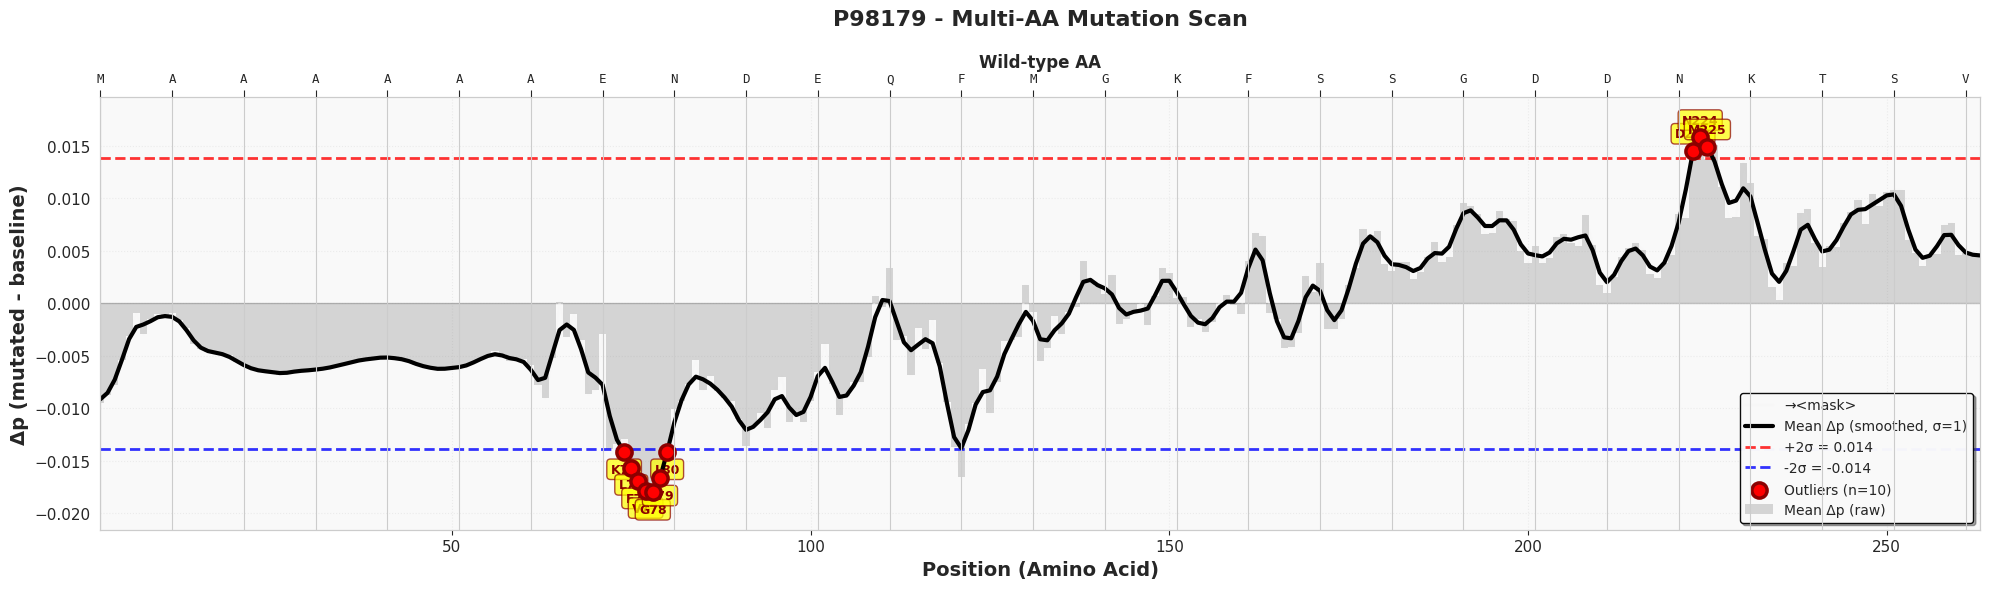

Outlier positions (|Δp| > 2σ):
  Position  74 (K): Δp = -0.0141
  Position  75 (L): Δp = -0.0156
  Position  76 (F): Δp = -0.0169
  Position  77 (V): Δp = -0.0178
  Position  78 (G): Δp = -0.0180
  Position  79 (G): Δp = -0.0166
  Position  80 (L): Δp = -0.0141
  Position 223 (D): Δp = +0.0145
  Position 224 (N): Δp = +0.0158
  Position 225 (M): Δp = +0.0149



In [ ]:
my_scanning.plot_multi_aa_scan(scan_results_biased, sigma=1,figsize=(20, 6), 
                        palette='RdBu_r', show_per_aa=True)#, xlim=[0,50])


# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

NameError: name 'data_df' is not defined

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=loss_fn, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


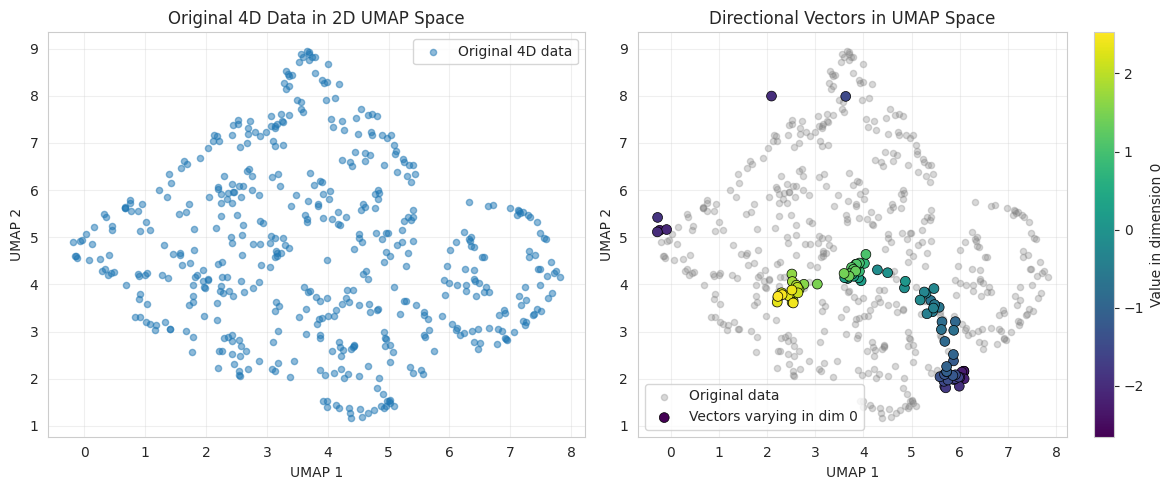

Original data shape: (500, 4)
Test vectors shape: (100, 4)
Test vectors vary from -2.65 to 2.53 in dimension 0


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

# Set random seed for reproducibility
np.random.seed(42)

# Create original 4D dataset
n_samples = 500
X_original = np.random.randn(n_samples, 4)

# Apply UMAP to reduce to 2D
umap_model = UMAP(n_components=2, random_state=42)
X_2d = umap_model.fit_transform(X_original)

# Create new vectors that vary along only one dimension
# Let's vary along dimension 0, keeping others at 0
n_test = 100
# Instead of varying along one dimension with others at 0,
# vary along one dimension while keeping others at their MEAN values
test_vectors = np.zeros((n_test, 4))
for i in range(4):
    test_vectors[:, i] = X_original[:, i].mean()  # Set to mean

# Now vary along dimension 0
test_vectors[:, 0] = np.linspace(
    X_original[:, 0].min(), 
    X_original[:, 0].max(), 
    n_test
)

# Transform these new vectors using the fitted UMAP
test_2d = umap_model.transform(test_vectors)

# Plot both datasets
plt.figure(figsize=(12, 5))

# Plot 1: Original data only
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, s=20, label='Original 4D data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Original 4D Data in 2D UMAP Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Original data + directional vectors
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.3, s=20, c='gray', label='Original data')
plt.scatter(test_2d[:, 0], test_2d[:, 1], c=test_vectors[:, 0], 
            cmap='viridis', s=50, edgecolors='black', linewidth=0.5,
            label='Vectors varying in dim 0')
plt.colorbar(label='Value in dimension 0')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Directional Vectors in UMAP Space')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some info
print(f"Original data shape: {X_original.shape}")
print(f"Test vectors shape: {test_vectors.shape}")
print(f"Test vectors vary from {test_vectors[:, 0].min():.2f} to {test_vectors[:, 0].max():.2f} in dimension 0")

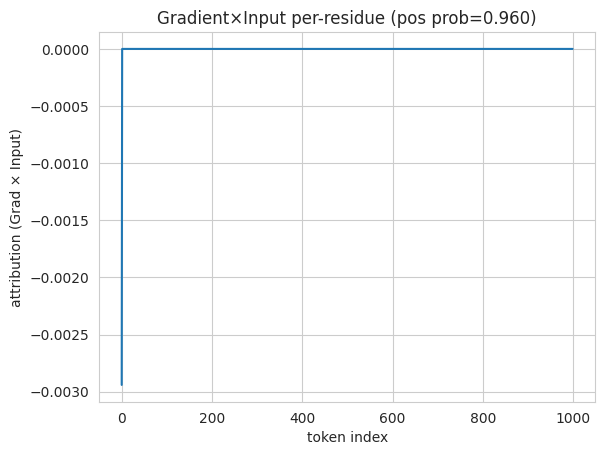

In [ ]:
import torch
import numpy as np
from typing import Tuple

import torch
import numpy as np
from typing import Tuple

def grad_x_input_for_one(
    net,
    esm_model,
    input_ids,
    attention_mask,
    pos_class=1,
    pool="cls",
    device="cuda",
):
    net.eval()
    esm_model.eval()

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # IMPORTANT: allow gradient graph!
    outputs = esm_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=True
    )

    token_embs = outputs.last_hidden_state  # [1, L, D]

    # We need gradient on token embeddings
    token_embs = token_embs.detach().clone().requires_grad_(True)

    # Pooling
    if pool == "cls":
        pooled = token_embs[:, 0, :]
    elif pool == "mean":
        emb = token_embs[:, 1:, :]         # drop CLS
        mask = attention_mask[:, 1:]       # drop CLS mask
        pooled = (emb * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)
    else:
        raise ValueError("Only 'cls' or 'mean' supported")

    # Forward into classifier head
    logits = net.class_head(pooled)  # shape [1, num_classes]

    pos_logit = logits[0, pos_class]

    # Compute gradient
    pos_logit.backward()

    grads = token_embs.grad.detach().squeeze(0)
    embs = token_embs.detach().squeeze(0)

    gx = grads * embs
    scores = gx.sum(dim=-1)

    prob = torch.softmax(logits, dim=-1)[0, pos_class].item()

    return scores.cpu(), prob




# assume you have:
# - net : EsmDeepSec (loaded, eval mode)
# - esm_model : the underlying ESM model (same used by net)
# - tokenizer : tokenizer that produced input_ids/attention_mask earlier
# - seq : raw sequence string (optional)

idx = [cache_data["protein"].index("P31483")] # encapslu in a lsit
selected_protein_data = my_dataset.subset_data_dict(cache_data, idx) #dict
selected_prot_emb=selected_protein_data["embedding"]
sequence = selected_protein_data["sequence"][0]
# Example: get tokenized tensors for a SINGLE sequence (shape [1, L])
enc = tokenizer([sequence], padding='max_length', truncation=True, max_length=1000, return_tensors="pt")
input_ids = enc["input_ids"]      # shape [1, L]
attention_mask = enc["attention_mask"]

scores, prob = grad_x_input_for_one(
    net=net,
    esm_model=esm_model,
    input_ids=input_ids,
    attention_mask=attention_mask,
    pos_class=1,
    pool="mean",
    device="cuda"
)

# visualize
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title(f"Gradient×Input per-residue (pos prob={prob:.3f})")
plt.xlabel("token index")
plt.ylabel("attribution (Grad × Input)")
plt.show()


In [43]:
assert all(not p.requires_grad for p in net.esm_model.parameters())
